### My DS

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset
import sklearn.datasets as skds
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
class MyDS(Dataset):
    def __init__(self, X,y,task='classification'):
        self.samples = torch.Tensor(X)
        if task=='classification': self.labels = torch.LongTensor(y)
        elif task=='regression': self.labels = torch.Tensor(y)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return (self.samples[idx],self.labels[idx])

## Model Implementation

#### Model (Classifier)

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

class DDTClassifier(nn.Module):
    def __init__(self, num_features = 25, num_classes = 5, beta = 0.1, depth = 6) -> None:
        super(DDTClassifier, self).__init__()

        ### some global constants
        self.n_features = num_features
        self.n_classes = num_classes

        ### beta would be common for all nodes-> the scaling constant in the temperature dependent sigmoid.
        self.beta = nn.Parameter(torch.Tensor([beta]))

        self.depth = depth  ### depth is the depth at which leaves would be present -> root is at depth 0,
                            ### its children at depth 0 and so on..
        ### binary tree calculations
        self.num_inner_nodes = (2 ** self.depth) -1

        ### for all 'num_inner_nodes' nodes there will be 'n_features' weights and 1 bias, this will be used along with
        ### the beta to calculate the output of the sigmoid.
        self.fc = nn.Linear(self.n_features, self.num_inner_nodes)

        ### standard binary tree calculation
        self.num_leaves = 2**self.depth

        ### each leaf would ideally be a probability distribution over the classes, however in our implementation
        ### we can interpret them as weights -> probability at each leaf (product of sigmoids) would be multiplied with the
        ### value of each class, and the resulting value for each class would be summed for all leaves,
        ### leaving us with a n_classes values for each datapoint, representing 1 of each class. After passing this through
        ### the softmax, we get the probabilities of each class
        self.leaves = nn.Parameter(torch.rand((self.num_leaves, self.n_classes)))

        ### the optimizer for the tree, ideally ADAM
        self.optimizer = None

        ### standard lists to keep track of stuff during training.
        self.loss_curve_ = None
        self.accuracies = None

    def params(self):
        ### to pass to the optimizer
        for param in self.parameters:
            yield  param

    def forward(self, x, train = False):
        ### setting the penalty as 0 before the forward pass
        penalty = torch.Tensor([0.])
        ### the primary function which drives the tree
        x = torch.Tensor(x)
        ### the sigmoid is applied on each node for all datapoints
        ### for each datapoint, at each node, sigmoid(beta(x*w-b)) is calculated.
        probs = torch.sigmoid(self.beta * self.fc(x)).T

        ### this list will hold the probabilties of each datapoint (carried on from the previous level)
        prev_probs = [torch.Tensor([1.]*probs[0].shape[0])]

        ### this is to replace alpha if incase alpha is 1 or 0 or nan
        epsilon = torch.Tensor([1e-4])

        for d in range(self.depth):
            next_depth = []

            init_id = 2**d-1
            for i in range(2**d):
                ### the sigmoid output at that node
                p = probs[init_id+i]
                ### the path probability for that node
                P = prev_probs[i]

                ### for the next depth, append P*p (left child) and P(1-p) (right child)
                next_depth.append(P*p) ###left child's path probability
                next_depth.append(P*(1-p))  ### right child's path probability

                ### alpha would be sum(P*p)/sum(P) where sum is over all the datapoints
                alpha =  torch.sum(P*p)/torch.sum(P)
                ### penalty would be subtracted by 2^-d * 0.5 * (log(alpha) + log(1-alpha))
                ### to prevent any issues we check if alpha is 1, 0 or nan
                if torch.isnan(alpha) or alpha == 0 or alpha == 1:
                    alpha = epsilon

                ### the coefficient for the penalty
                lambda_ = 2**(-d)
                ### penalty update
                penalty -= lambda_ * 0.5 * (torch.log2(alpha)+torch.log2(1-alpha))

            ### make prev_probs as the next_depth for the new iteration
            prev_probs = next_depth

        ### now that we have path probabilities at each leaf, we multiply it with the distribution at respective leaf
        ### the resultant value for each class would be summed over all the leaves.
        prev_probs = torch.stack(prev_probs)
        out = torch.sum(prev_probs.unsqueeze(2) * self.leaves.unsqueeze(1), axis = 0)
        ### getting the final output

        ls = nn.LogSoftmax()
        sf = nn.Softmax()

        ### worst case scenario -> change beta or learning rate in this case
        if torch.isinf(penalty):
            penalty = 0

        if train:
            return ls(out), penalty
        else:
            return sf(out)


    def fit(self, X, Y, epochs = 2, lr = 0.01, batch_size = 32, penalty_coeff = 1): ## chagned to fit from train
        self.optimizer = optim.Adam(self.parameters(), lr = lr)
        self.criterion = nn.NLLLoss()
        X = torch.Tensor(X)
        Y = torch.LongTensor(Y)
        if self.loss_curve_ is None:
            self.loss_curve_ = []
        if self.accuracies is None:
            self.accuracies = []
        dsloader = torch.utils.data.DataLoader(list(zip(X,Y)), shuffle = True, batch_size = batch_size)
        for epoch in tqdm(range(epochs)):
            l = 0
            n = 0
            for batch_x, batch_y in dsloader:
                self.optimizer.zero_grad()
                output, penalty = self.forward(batch_x, train=True)
                loss = self.criterion(output, batch_y) + penalty_coeff * penalty
                l += loss.item()
                n += 1
                loss.backward()
                torch.nn.utils.clip_grad_value_(self.parameters(), 1e3)
                self.optimizer.step()
            self.loss_curve_.append(l/n)
            self.accuracies.append(self.accuracy(X, Y))

    def accuracy(self, X, y):
        output = torch.argmax(self.forward(X, train=False), axis = 1)
        return sum([pred == gt for pred,gt in zip(output, y)])/output.shape[0]


    def prune(self, probs, max_impurity = 0.6):
        gini_impurity = 1 - torch.sum(torch.square(probs))
        return False if gini_impurity <= max_impurity else True


#### Model (Regressor) *fix

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

class DDTRegressor(nn.Module):
    def __init__(self, num_features = 25, beta = 0.1, depth = 6) -> None:
        super(DDTRegressor, self).__init__()

        ### some global constants
        self.n_features = num_features

        ### beta would be common for all nodes-> the scaling constant in the temperature dependent sigmoid.
        self.beta = nn.Parameter(torch.Tensor([beta]))

        self.depth = depth  ### depth is the depth at which leaves would be present -> root is at depth 0,
                            ### its children at depth 0 and so on..
        ### binary tree calculations
        self.num_inner_nodes = (2 ** self.depth) -1

        ### for all 'num_inner_nodes' nodes there will be 'n_features' weights and 1 bias, this will be used along with
        ### the beta to calculate the output of the sigmoid.
        self.fc = nn.Linear(self.n_features, self.num_inner_nodes)

        ### standard binary tree calculation
        self.num_leaves = 2**self.depth

        ### each leaf would ideally be a probability distribution over the classes, however in our implementation
        ### we can interpret them as weights -> probability at each leaf (product of sigmoids) would be multiplied with the
        ### value of each class, and the resulting value for each class would be summed for all leaves,
        ### leaving us with a n_classes values for each datapoint, representing 1 of each class. After passing this through
        ### the softmax, we get the probabilities of each class
        self.leaves = nn.Linear(self.n_features, self.num_leaves)

        ### the optimizer for the tree, ideally ADAM
        self.optimizer = None

        ### standard lists to keep track of stuff during training.
        self.loss_curve_ = None
        self.accuracies = None

    def params(self):
        ### to pass to the optimizer
        for param in self.parameters:
            yield  param

    def forward(self, x, train = False):
        ### setting the penalty as 0 before the forward pass
        penalty = torch.Tensor([0.])
        ### the primary function which drives the tree
        x = torch.Tensor(x)
        ### the sigmoid is applied on each node for all datapoints
        ### for each datapoint, at each node, sigmoid(beta(x*w-b)) is calculated.
        probs = torch.sigmoid(self.beta * self.fc(x)).T

        reg_outputs = self.leaves(x).T
        ### this list will hold the probabilties of each datapoint (carried on from the previous level)
        prev_probs = [torch.Tensor([1.]*probs[0].shape[0])]

        ### this is to replace alpha if incase alpha is 1 or 0 or nan
        epsilon = torch.Tensor([1e-4])

        for d in range(self.depth):
            next_depth = []

            init_id = 2**d-1
            for i in range(2**d):
                ### the sigmoid output at that node
                p = probs[init_id+i]
                ### the path probability for that node
                P = prev_probs[i]

                ### for the next depth, append P*p (left child) and P(1-p) (right child)
                next_depth.append(P*p) ###left child's path probability
                next_depth.append(P*(1-p))  ### right child's path probability

                ### alpha would be sum(P*p)/sum(P) where sum is over all the datapoints
                alpha =  torch.sum(P*p)/torch.sum(P)
                ### penalty would be subtracted by 2^-d * 0.5 * (log(alpha) + log(1-alpha))
                ### to prevent any issues we check if alpha is 1, 0 or nan
                if torch.isnan(alpha) or alpha == 0 or alpha == 1:
                    alpha = epsilon

                ### the coefficient for the penalty
                lambda_ = 2**(-d)
                ### penalty update
                penalty -= lambda_ * 0.5 * (torch.log2(alpha)+torch.log2(1-alpha))

            ### make prev_probs as the next_depth for the new iteration
            prev_probs = next_depth

        ### now that we have path probabilities at each leaf, we multiply it with the distribution at respective leaf
        ### the resultant value for each class would be summed over all the leaves.
        prev_probs = torch.stack(prev_probs)
        out = torch.sum(prev_probs.unsqueeze(2) * reg_outputs.unsqueeze(1), axis = 0)

        ### worst case scenario -> change beta or learning rate in this case
        if torch.isinf(penalty):
            penalty = 0

        if train:
            return out, penalty
        else:
            return out


    def train(self, X, Y, epochs = 2, lr = 0.01, batch_size = 32, penalty_coeff = 1):
        self.optimizer = optim.Adam(self.parameters(), lr = lr)
        self.criterion = nn.MSELoss()
        X = torch.Tensor(X)
        Y = torch.Tensor(Y)
        if self.loss_curve_ is None:
            self.loss_curve_ = []
        if self.accuracies is None:
            self.accuracies = []
        dsloader = torch.utils.data.DataLoader(list(zip(X,Y)), shuffle = True, batch_size = batch_size)
        for epoch in tqdm(range(epochs)):
            l = 0
            n = 0
            for batch_x, batch_y in dsloader:
                self.optimizer.zero_grad()
                output, penalty = self.forward(batch_x, train=True)
                loss = self.criterion(output, batch_y) + penalty_coeff * penalty
                l += loss.item()
                n += 1
                loss.backward()
                torch.nn.utils.clip_grad_value_(self.parameters(), 1e3)
                self.optimizer.step()
            self.loss_curve_.append(l/n)

    def score(self, X, y):
        rmse = torch.sqrt(torch.mean(torch.square(self.forward(X)-y)))
        return rmse


#### ensemble code

In [10]:
class DDTEnsemble():
    def __init__(self, max_impurity=0.6, levels = 3, max_depth = 6, features = 25, classes = 5):
        ### necessary hyperparameters
        self.max_depth = max_depth
        self.max_impurity = max_impurity
        self.levels = levels

        ### lists for later use - making graphs and tables
        self.models = None
        self.train_accs = None
        self.unpruned_train_data = None
        self.test_accs = None
        self.unpruned_test_data = None
        self.features = features
        self.classes = classes

        ### accs on the entire data from the base model - for comparison
        self.base_train_acc = None
        self.base_test_acc = None

        ### contains the test confusion matrices
        self.base_test_cm = None
        self.cascaded_test_cm = None

    def fit(self, dstrain, dstest, beta = 0.1, epochs = 1000, lr = 0.01, batch_size = 32, penalty_coeff = 1):
        ### list contains all the trees in the ensemble
        self.models = []

        ### contains all the train accs and their support for each tree - 0 for both indicates there was no train data
        self.train_accs = []
        self.unpruned_train_data = []

        ### contains all the test accs and their support for each tree - 0 for both indicates there was no test data
        self.test_accs = []
        self.unpruned_test_data = []

        ### these will contain values for the confusion matrix
        testgt = []
        testpred  = []

        trainX, testX, trainy, testy = dstrain.samples, dstest.samples, dstrain.labels, dstest.labels

        ### run the loop to get 'levels' number of models
        for level in range(self.levels):

            ### if no data was pruned in the previous iteration we just append to 0 to everything (keep max_impurity about 0.6)
            tot = len(trainX)
            if tot == 0:
                self.train_accs.append(0)
                self.unpruned_train_data.append(0)
                self.test_accs.append(0)
                self.unpruned_test_data.append(0)
                continue

            ### if there is an non empty train dataset- build tree and train according to hyperparameters.
            softTree = DDTClassifier(num_features=self.features, num_classes=self.classes, depth=self.max_depth, beta = beta)

            softTree.train() ## added this
            ### train the ddt as usual
            softTree.fit(trainX, trainy, epochs = epochs, lr = lr, batch_size = batch_size, penalty_coeff = penalty_coeff) ##made this fit

            ### append generated and trained ddt to list of models
            self.models.append(softTree)

            ### if its the base model(level 0) record acc on entire data
            if level == 0:
                self.base_train_acc = softTree.accuracy(trainX, trainy).item()
                self.base_test_acc = softTree.accuracy(testX, testy).item()
                ### make the confusion matrix from the base model predictions
                self.base_test_cm = confusion_matrix(testy, torch.argmax(softTree.forward(testX,train=False),axis=1).numpy())

            ### Train prediction + pruning ###
            ### append the train acc on the unpruned train data and the percentage of data that wasnt pruned from the training set.
            cor = 0
            output = softTree.forward(trainX, train = False)
            ### train dataset consisting of pruned points for the next iteration
            X_new = []
            y_new = []
            ### the number of datapoints that were pruned.
            prunes = 0
            for i, pred in enumerate(output):
                if not softTree.prune(pred, max_impurity = self.max_impurity):
                    ### if not to be pruned
                    if torch.argmax(pred) == trainy[i]:
                        cor += 1
                else:
                    ### if prune func returns True: datapoint must be pruned- increment prunes and append point to new dataset
                    prunes += 1
                    X_new.append(trainX[i])
                    y_new.append(trainy[i])

            ### replaces older dataset with the newer ones which solely contains the pruned datapoints.
            if X_new:
              trainX = np.stack(X_new)
              trainy = np.stack(y_new)
            else:
              trainX = []
              trainy = []

            ### tot-prunes is the number of unpruned datapoints - appending percentage of points not pruned - the support
            unpruned = (tot-prunes)/tot
            self.unpruned_train_data.append(unpruned)

            ### if all datapoints were pruned - we dont make a prediction on this dataset at all : added 0 to indicate the same
            if prunes == tot:
                self.train_accs.append(0)
            else:
                ### acc is number of correct predictions on unpruned datapoints, tot-prunes is total unpruned datapoints
                acc = cor/(tot-prunes)
                self.train_accs.append(acc)


            ### Test prediction + pruning ###
            softTree.eval()
            tot = len(testX)
            ### if number of datapoints in test data is 0, there is no test data to make a prediction on. Hence adding 0s.
            ### Not breaking the loop as I want to maintain the sizes of the lists to be equal to the number of levels.
            if tot == 0:
                self.test_accs.append(0)
                self.unpruned_test_data.append(0)
                continue

            ### standard - setting correct to 0, getting outputs on test
            cor = 0
            output = softTree.forward(testX, train = False)

            ### test dataset consisting of pruned points for the next iteration
            newTestX = []
            newTesty = []

            ### number of pruned points
            prunes = 0

            ### standard loop - checks if point is to be pruned or not and accordingly calculates accuracy or adds to new dataset
            for i, pred in enumerate(output):
                if not softTree.prune(pred, max_impurity = self.max_impurity):
                    testgt.append(testy[i])
                    testpred.append(torch.argmax(pred).item())
                    if torch.argmax(pred) == testy[i]:
                        cor += 1
                else:
                    ### same thing as for the train
                    prunes += 1
                    newTestX.append(testX[i])
                    newTesty.append(testy[i])

            ### creates the new test dataset for the next iteration.
            if newTestX:
              testX = np.stack(newTestX)
              testy = np.stack(newTesty)
            else:
              testX = []
              testy = []

            ### tot-prunes is the number of unpruned datapoints - appending percentage of points not pruned - the support
            unpruned = (tot-prunes)/tot
            self.unpruned_test_data.append(unpruned)

            ### if all datapoints were pruned - we dont make a prediction on this dataset at all : added 0 to indicate the same
            if prunes == tot:
                self.test_accs.append(0)
            else:
                ### acc is number of correct predictions on unpruned datapoints, tot-prunes is total unpruned datapoints
                acc = cor/(tot-prunes)
                self.test_accs.append(acc)

        ### the confusion matrix on the unpruned test data
        self.cascaded_test_cm = confusion_matrix(testgt, testpred)

    # def forward(self, X):
    #     output = []
    #     for x in X:
    #         p = None
    #         for model in self.models:
    #             p = model.forward(x)
    #             if not model.prune(p, self.max_impurity):
    #                 break
    #             else:
    #                 temp = -torch.ones(p.size)
    #                 p = temp
    #         output.append(p)
    #     output = torch.stack(output)
    #     return output
    
    def forward(self,x,max_impurity=None):
        if max_impurity is None: max_impurity=self.max_impurity
        n=x.shape[0]
        output=[]
        for i in range(n):
            probs=-torch.ones(self.classes)
            for model in self.models:
                p=model.forward(x[i,:].unsqueeze(0)).squeeze()
                if not model.prune(p,max_impurity):
                    probs=p
                    break
            output.append(probs)
        return torch.stack(output)
                    

    def utility(self, preds, gt):
        utility = 0
        for i, pred in enumerate(preds):
            if pred == -1:
                continue
            elif pred == 0:
                utility += -(gt-2) ###4->-2 0->+2
            elif pred == 4:
                utility += (gt-2)

        return utility

    def save_models(self, path):
        model_weights = {}
        for i,model in enumerate(self.models):
            model_weights[f"model{i}"] = model.state_dict()
        torch.save(model_weights, path)

    def load_models(self, path, num_features = 25, num_classes = 5, beta = 0.1, depth = 6):
        self.models =  []
        checkpoint = torch.load(path)
        for i in range(self.levels):
            if f"model{i}" in checkpoint:
                model = DDTClassifier(num_features = num_features, num_classes = num_classes, beta = beta, depth = depth)
                model.load_state_dict(checkpoint[f"model{i}"])
                self.models.append(model)           

#### Ordinal CLassification

In [11]:
### implementing ordinal classifier

class OrdinalDDTClassifier(nn.Module):
    def __init__(self, num_features = 25, num_classes = 5, beta = 0.1, depth = 6) -> None:
        super(DDTClassifier, self).__init__()

        ### some global constants
        self.n_features = num_features
        self.n_classes = num_classes

        ### beta would be common for all nodes-> the scaling constant in the temperature dependent sigmoid.
        self.beta = nn.Parameter(torch.Tensor([beta]))

        self.depth = depth  ### depth is the depth at which leaves would be present -> root is at depth 0,
                            ### its children at depth 0 and so on..
        ### binary tree calculations
        self.num_inner_nodes = (2 ** self.depth) -1

        ### for all 'num_inner_nodes' nodes there will be 'n_features' weights and 1 bias, this will be used along with
        ### the beta to calculate the output of the sigmoid.
        self.fc = nn.Linear(self.n_features, self.num_inner_nodes)

        ### standard binary tree calculation
        self.num_leaves = 2**self.depth

        ### each leaf would ideally be a probability distribution over the classes, however in our implementation
        ### we can interpret them as weights -> probability at each leaf (product of sigmoids) would be multiplied with the
        ### value of each class, and the resulting value for each class would be summed for all leaves,
        ### leaving us with a n_classes values for each datapoint, representing 1 of each class. After passing this through
        ### the softmax, we get the probabilities of each class
        self.leaves = nn.Parameter(torch.rand((self.num_leaves, self.n_classes-1)))

        ### the optimizer for the tree, ideally ADAM
        self.optimizer = None

        ### standard lists to keep track of stuff during training.
        self.loss_curve_ = None
        self.accuracies = None

    def params(self):
        ### to pass to the optimizer
        for param in self.parameters:
            yield  param

    def forward(self, x, train = False):
        ### setting the penalty as 0 before the forward pass
        penalty = torch.Tensor([0.])
        ### the primary function which drives the tree
        x = torch.Tensor(x)
        ### the sigmoid is applied on each node for all datapoints
        ### for each datapoint, at each node, sigmoid(beta(x*w-b)) is calculated.
        probs = torch.sigmoid(self.beta * self.fc(x)).T

        ### this list will hold the probabilties of each datapoint (carried on from the previous level)
        prev_probs = [torch.Tensor([1.]*probs[0].shape[0])]

        ### this is to replace alpha if incase alpha is 1 or 0 or nan
        epsilon = torch.Tensor([1e-4])

        for d in range(self.depth):
            next_depth = []

            init_id = 2**d-1
            for i in range(2**d):
                ### the sigmoid output at that node
                p = probs[init_id+i]
                ### the path probability for that node
                P = prev_probs[i]

                ### for the next depth, append P*p (left child) and P(1-p) (right child)
                next_depth.append(P*p) ###left child's path probability
                next_depth.append(P*(1-p))  ### right child's path probability

                ### alpha would be sum(P*p)/sum(P) where sum is over all the datapoints
                alpha =  torch.sum(P*p)/torch.sum(P)
                ### penalty would be subtracted by 2^-d * 0.5 * (log(alpha) + log(1-alpha))
                ### to prevent any issues we check if alpha is 1, 0 or nan
                if torch.isnan(alpha) or alpha == 0 or alpha == 1:
                    alpha = epsilon

                ### the coefficient for the penalty
                lambda_ = 2**(-d)
                ### penalty update
                penalty -= lambda_ * 0.5 * (torch.log2(alpha)+torch.log2(1-alpha))

            ### make prev_probs as the next_depth for the new iteration
            prev_probs = next_depth

        ### now that we have path probabilities at each leaf, we multiply it with the distribution at respective leaf
        ### the resultant value for each class would be summed over all the leaves.
        prev_probs = torch.stack(prev_probs)
        out = torch.sum(prev_probs.unsqueeze(2) * self.leaves.unsqueeze(1), axis = 0)

        ### getting the final output
        ### we model each n_classes-1 outputs where each k in (0,n_classes-2) denote the probability that the class is >k
        out = torch.sigmoid(out)
        fin = []
        for i in range(self.n_classes):
            if i==0:
                fin.append(1-out[:,i])
            elif i==self.n_classes-1:
                fin.append(out[:,i])
            else:
                fin.append(torch.abs(out[:,i-1]-out[:,i]))

        fin = torch.stack(fin)

        ### worst case scenario -> change beta or learning rate in this case
        if torch.isinf(penalty):
            penalty = 0

        if train:
            return fin, penalty
        else:
            return fin


    def train(self, X, Y, epochs = 2, lr = 0.01, batch_size = 32, penalty_coeff = 1):
        self.optimizer = optim.Adam(self.parameters(), lr = lr)
        self.criterion = nn.NLLLoss()
        X = torch.Tensor(X)
        Y = torch.LongTensor(Y)
        if self.loss_curve_ is None:
            self.loss_curve_ = []
        if self.accuracies is None:
            self.accuracies = []
        dsloader = torch.utils.data.DataLoader(list(zip(X,Y)), shuffle = True, batch_size = batch_size)
        for epoch in tqdm(range(epochs)):
            l = 0
            n = 0
            for batch_x, batch_y in dsloader:
                self.optimizer.zero_grad()
                output, penalty = self.forward(batch_x, train=True)
                loss = self.criterion(output, batch_y) + penalty_coeff * penalty
                l += loss.item()
                n += 1
                loss.backward()
                torch.nn.utils.clip_grad_value_(self.parameters(), 1e3)
                self.optimizer.step()
            self.loss_curve_.append(l/n)
            self.accuracies.append(self.accuracy(X, Y))

    def accuracy(self, X, y):
        output = torch.argmax(self.forward(X, train=False), axis = 1)
        return sum([pred == gt for pred,gt in zip(output, y)])/output.shape[0]


    def prune(self, probs, max_impurity = 0.6):
        gini_impurity = 1 - torch.sum(torch.square(probs))
        return False if gini_impurity <= max_impurity else True


# Experiments

### Hyperparameters

In [6]:
ensemble_params = {'levels': 3, 'max_impurity': 0.5, 'max_depth': 6}
fit_params = {'epochs': 500, 'lr': 0.01, 'batch_size': 32, 'penalty_coeff': 1, 'beta':0.5}

### Initial stuff

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
COLS=['row_num',
 'Open_n_val',
 'High_n_val',
 'Low_n_val',
 'Close_n_val',
 'Volume_n_val',
 'SMA_10_val',
 'SMA_20_val',
 'CMO_14_val',
 'High_n-Low_n_val',
 'Open_n-Close_n_val',
 'SMA_20-SMA_10_val',
 'Close_n_slope_3_val',
 'Close_n_slope_5_val',
 'Close_n_slope_10_val',
 'Open_n_changelen_val',
 'High_n_changelen_val',
 'Low_n_changelen_val',
 'Close_n_changelen_val',
 'High_n-Low_n_changelen_val',
 'Open_n-Close_n_changelen_val',
 'SMA_20-SMA_10_changelen_val',
 'Close_n_slope_3_changelen_val',
 'Close_n_slope_5_changelen_val',
 'Close_n_slope_10_changelen_val']
COLS=COLS+['target_5_val','target_10_val','era','day']
sigmaL=[[0,0],[0,.05],[.01,0],[.01,.05],[.03,0],[.05,.05],[.075,0],[.075,.05]]
DATAPATH='archive/'

## Experiments on df_syn_x_x

### Training and testing on same set of eras (confusion done)

In [13]:
train_accs = []
test_accs = []
train_unpruned = []
test_unpruned = []
base_train = []
base_test = []
cms = []
levels = 3
for sid in sigmaL:
    print(f"{sid}")
    df_train=pd.read_csv(DATAPATH+f'df_syn_train_{sid[0]}_{sid[1]}_.csv')[COLS]
    df_test=pd.read_csv(DATAPATH+f'df_syn_test_{sid[0]}_{sid[1]}_.csv')[COLS]
    eras = df_train['era'].unique()
    trainf = pd.DataFrame()
    testf = pd.DataFrame()

    for e in eras:
        df=df_train.loc[df_train['era'] == e]
        train, test = df[0:int(0.8*df.shape[0])], df[int(0.8*df.shape[0]):]
        trainf = pd.concat([trainf, train])
        testf = pd.concat([testf, test])

    ds_train=MyDS(trainf.iloc[:,0:-4].values,trainf.iloc[:,-3].values,task='regression')
    ds_test=MyDS(testf.iloc[:,0:-4].values,testf.iloc[:,-3].values,task='regression')
    ds_train.labels=np.array([int(l*4) for l in ds_train.labels])
    ds_test.labels=np.array([int(l*4) for l in ds_test.labels])

    ensemble = DDTEnsemble(**ensemble_params)
    ensemble.fit(ds_train, ds_test, **fit_params)
    cms.append((ensemble.base_test_cm, ensemble.cascaded_test_cm))

    train_unpruned.append(ensemble.unpruned_train_data)
    train_accs.append(ensemble.train_accs)
    test_unpruned.append(ensemble.unpruned_test_data)
    test_accs.append(ensemble.test_accs)
    base_train.append(ensemble.base_train_acc)
    base_test.append(ensemble.base_test_acc)

    display.clear_output(wait = True)
print("DONE.")

[0, 0]


  0%|          | 0/500 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/py311aml/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311aml/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  5%|▌         | 25/500 [00:32<10:27,  1.32s/it]

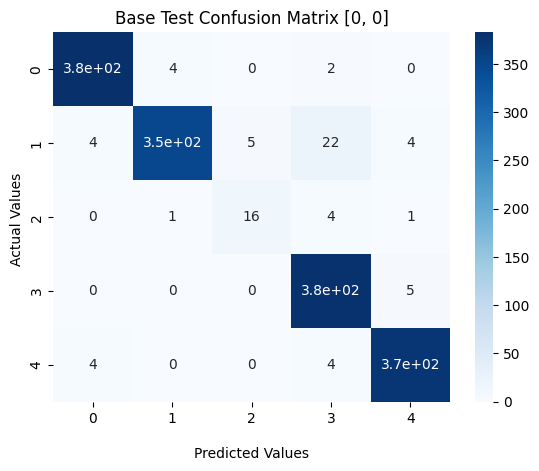

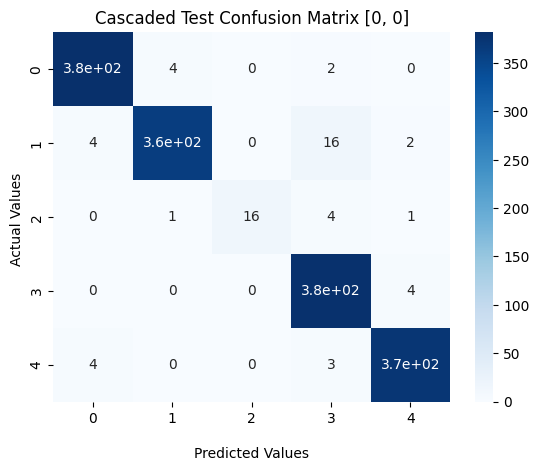

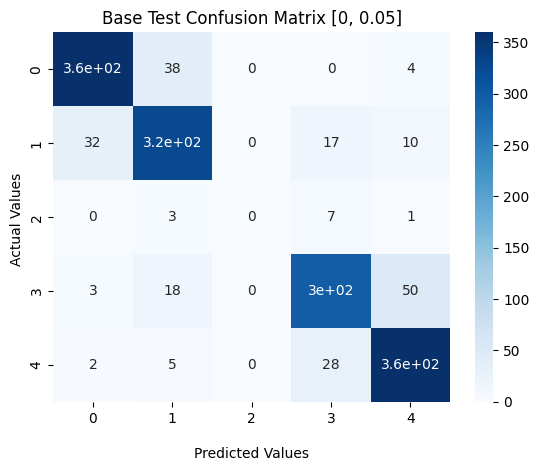

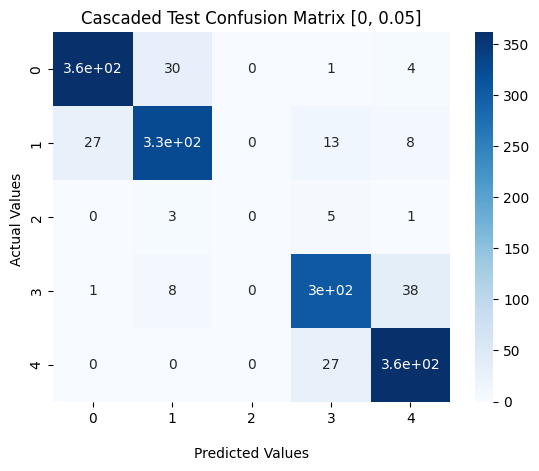

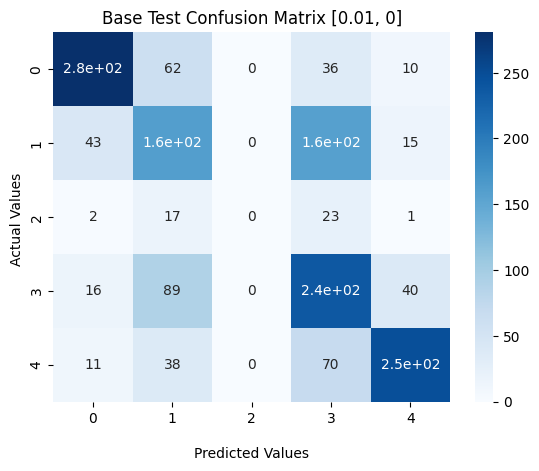

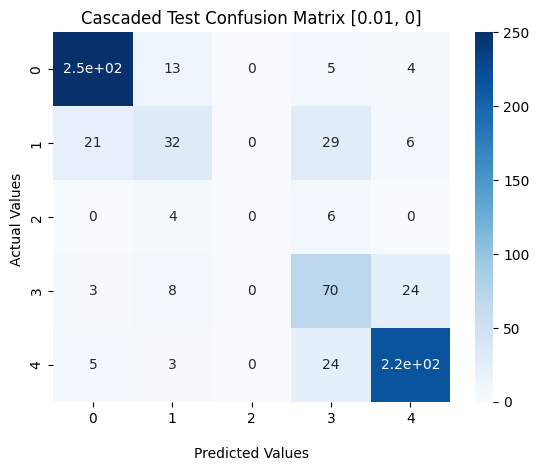

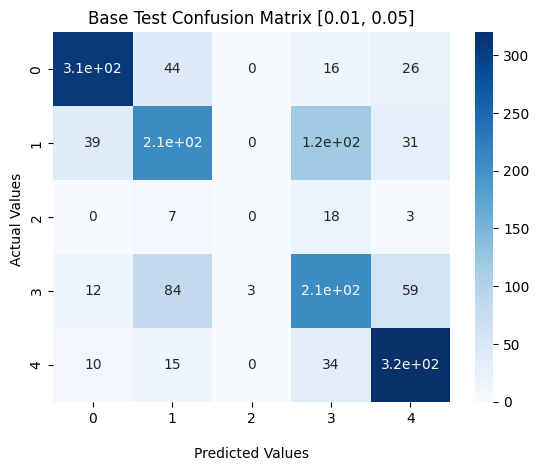

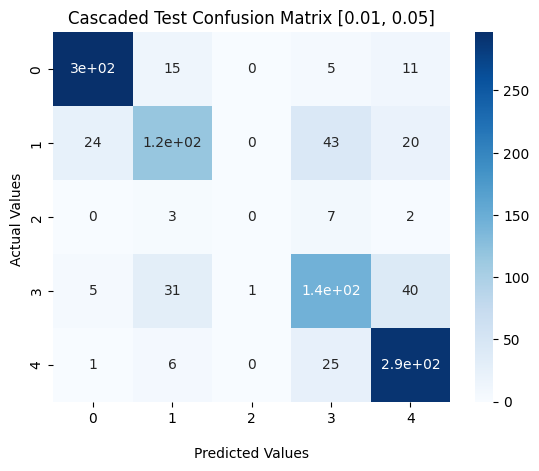

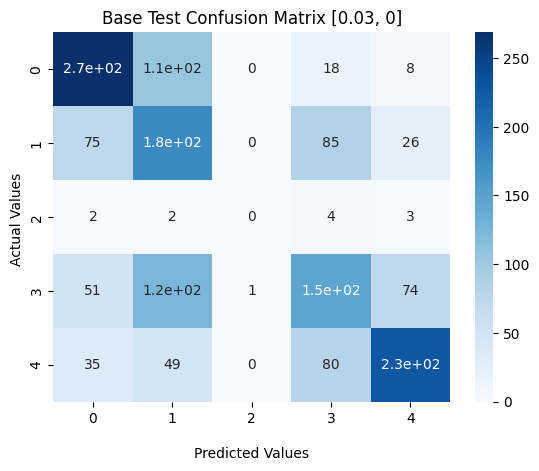

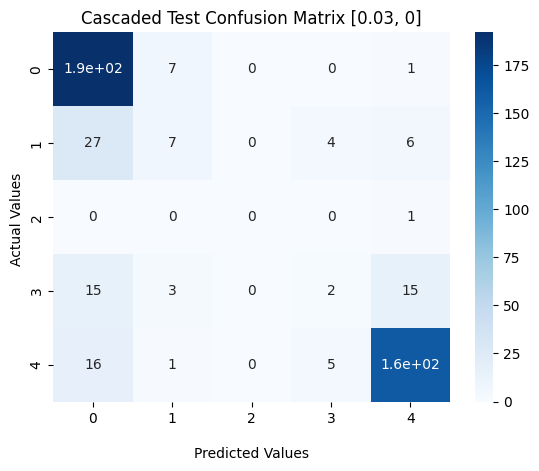

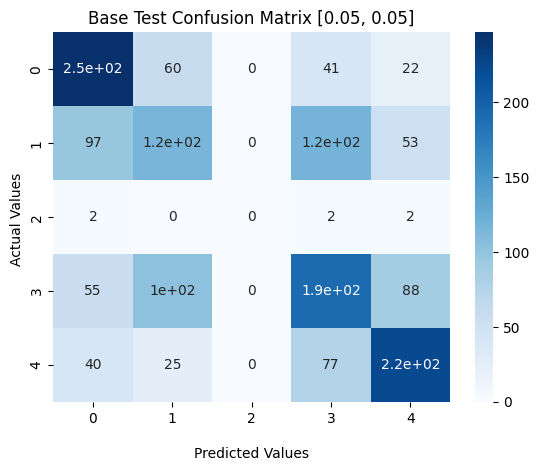

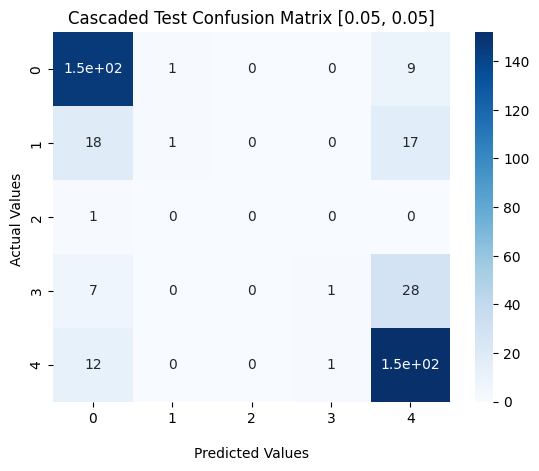

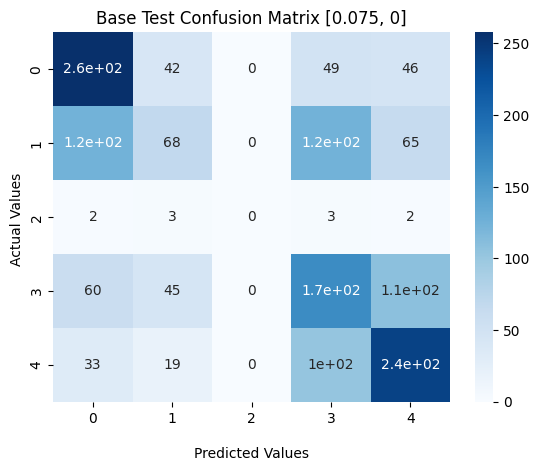

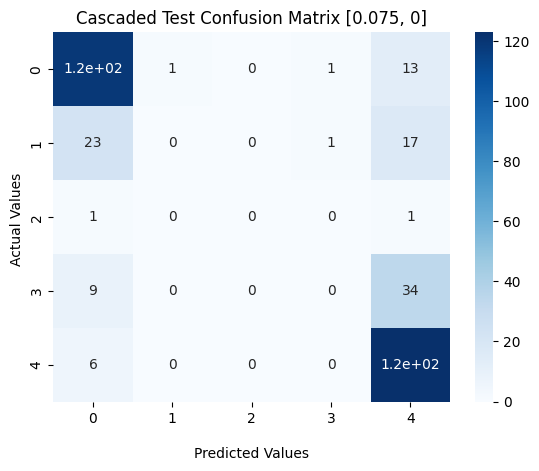

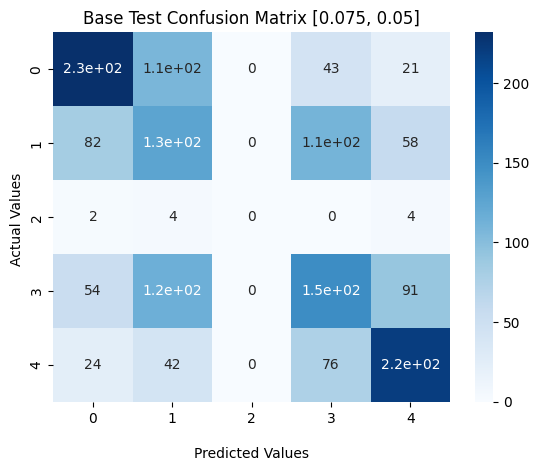

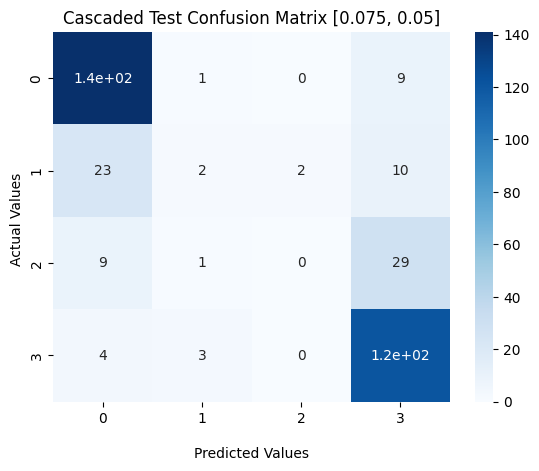

In [ ]:
for i, cm in enumerate(cms):
    base_cm, cascaded_cm = cm
     ### base test confusion matrix
    disp = sns.heatmap(base_cm, annot = True, cmap = 'Blues')
    disp.set_title(f"Base Test Confusion Matrix {sigmaL[i]}")
    disp.set_xlabel('\nPredicted Values')
    disp.set_ylabel('Actual Values ');
    disp.xaxis.set_ticklabels([0,1,2,3,4])
    disp.yaxis.set_ticklabels([0,1,2,3,4])
    plt.show()

    disp = sns.heatmap(cascaded_cm, annot = True, cmap = 'Blues')
    disp.set_title(f"Cascaded Test Confusion Matrix {sigmaL[i]}")
    disp.set_xlabel('\nPredicted Values')
    disp.set_ylabel('Actual Values ');
    plt.show()

In [ ]:
### calculate weighted sum of accs
train_comb = []
test_comb = []
train_support = []
test_support = []
for s in range(len(sigmaL)):
    train_acc = 0
    test_acc = 0
    train_left = 1
    test_left = 1
    for i in range(levels):
        train_acc += train_accs[s][i] * train_unpruned[s][i] * train_left
        test_acc += test_accs[s][i] * test_unpruned[s][i] * test_left
        train_left -= train_unpruned[s][i] * train_left
        test_left -= test_unpruned[s][i] * test_left
    train_comb.append(train_acc/(1-train_left))
    test_comb.append(test_acc/(1-test_left))
    train_support.append(1-train_left)
    test_support.append(1-test_left)

In [ ]:
table = "<table>\n"
table += "<thead><caption>Training on data from all eras and testing on data with same set of eras.</caption>\n"
table += "<th>Noise</th>"
for i in range(levels):
    table += f"<th colspan = \"4\">MODEL {i+1}</th>"
table += f"<th colspan = \"2\">BASE MODEL</th><th colspan = \"4\">COMBINATION</th>"
table += "\n"
table += "</thead><tbody>\n<tr>"
table += "<td></td>"
for i in range(levels):
    table += "<td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td>"
table += "<td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td>"
table += "</tr>\n"
for s in range(len(sigmaL)):
    table += f"<tr><td>{sigmaL[s]}</td>"
    for i in range(levels):
        table += f"<td>{train_accs[s][i]:.3f}</td>"
        table += f"<td>{train_unpruned[s][i]:.3f}</td>"
        table += f"<td>{test_accs[s][i]:.3f}</td>"
        table += f"<td>{train_unpruned[s][i]:.3f}</td>"
        table += "\n"
    table += f"<td>{base_train[s]:.3f}</td><td>{base_test[s]:.3f}</td><td>{train_comb[s]:.3f}</td><td>{test_comb[s]:.3f}</td><td>{train_support[s]:.3f}</td><td>{test_support[s]:.3f}</td>\n"
    table += "</tr>"
table += "</tbody></table>"
print(table)

<table>
<thead><caption>Training on data from all eras and testing on data with same set of eras.</caption>
<th>Noise</th><th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td></td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>[0, 0]</td><td>0.975</td><td>0.968</td><td>0.973</td><td>0.968</td>
<td>0.887</td><td>0.800</td><td>0.913</td><td>0.800</td>
<td>1.000</td><td>0.525</td><td>1.000</td><td>0.525</td>
<td>0.964</td><td>0.964</td><td>0.973</td><td>0.972</td><td>0.997</td><td>0.993</td>
</tr><tr><td>[0, 0.05]</td><td>0.960</td><td>0.915</td><t

### Train on set of eras test on different set of eras (confusion done)

In [ ]:
train_accs = []
test_accs = []
train_unpruned = []
test_unpruned = []
base_train = []
base_test = []
cms = []
levels = 3
for sid in sigmaL:
    print(f"{sid}")
    trainf=pd.read_csv(DATAPATH+f'df_syn_train_{sid[0]}_{sid[1]}_.csv')[COLS]
    testf=pd.read_csv(DATAPATH+f'df_syn_train_test_{sid[0]}_{sid[1]}_.csv')[COLS]

    ds_train=MyDS(trainf.iloc[:,0:-4].values,trainf.iloc[:,-3].values,task='regression')
    ds_test=MyDS(testf.iloc[:,0:-4].values,testf.iloc[:,-3].values,task='regression')
    ds_train.labels=np.array([int(l*4) for l in ds_train.labels])
    ds_test.labels=np.array([int(l*4) for l in ds_test.labels])

    ensemble = Ensemble(**ensemble_params)
    ensemble.fit(ds_train, ds_test, **fit_params)
    cms.append((ensemble.base_test_cm, ensemble.cascaded_test_cm))

    train_unpruned.append(ensemble.unpruned_train_data)
    train_accs.append(ensemble.train_accs)
    test_unpruned.append(ensemble.unpruned_test_data)
    test_accs.append(ensemble.test_accs)
    base_train.append(ensemble.base_train_acc)
    base_test.append(ensemble.base_test_acc)

    display.clear_output(wait = True)
print("DONE.")

DONE.


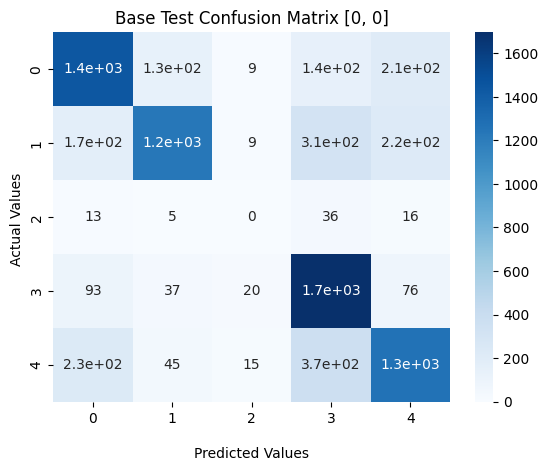

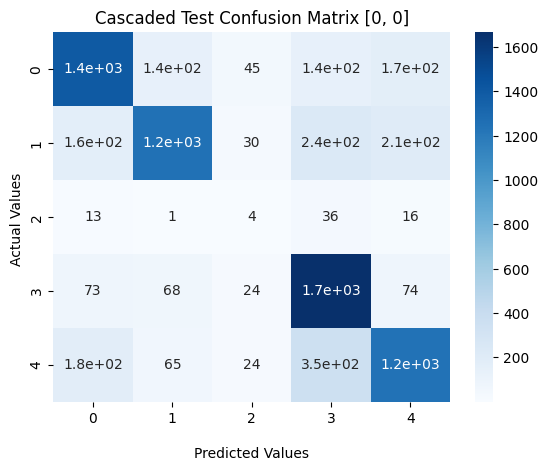

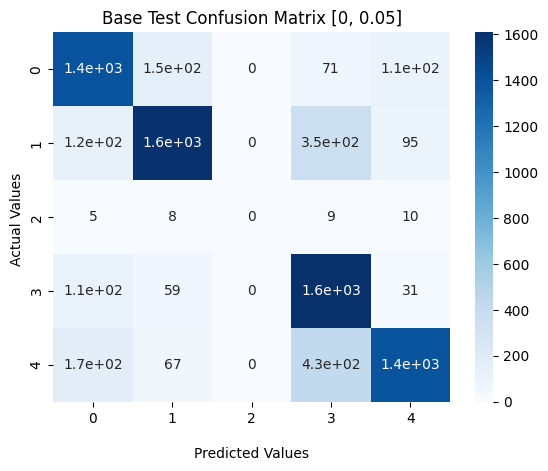

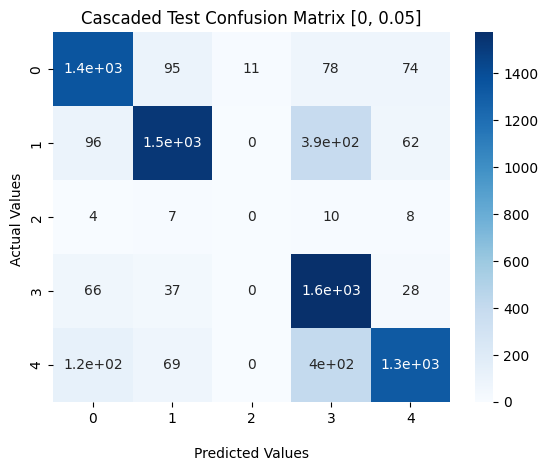

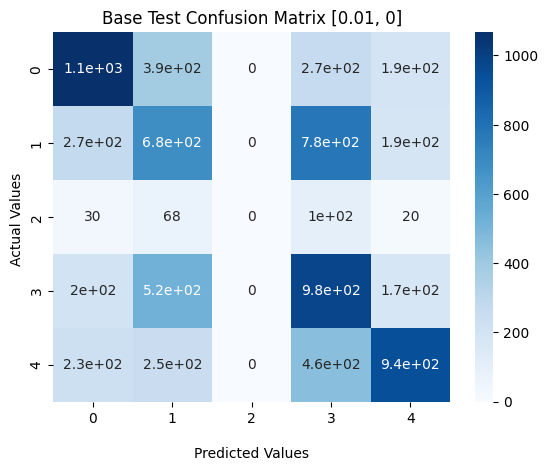

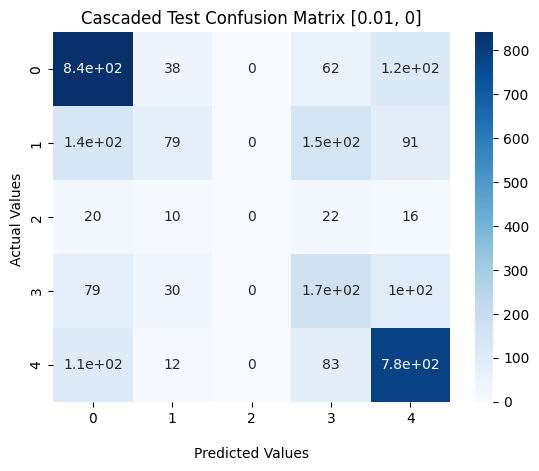

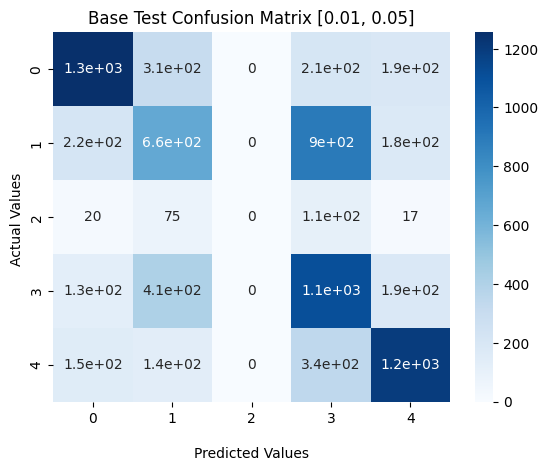

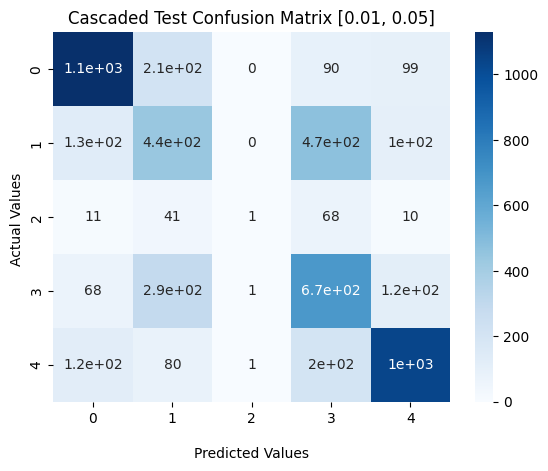

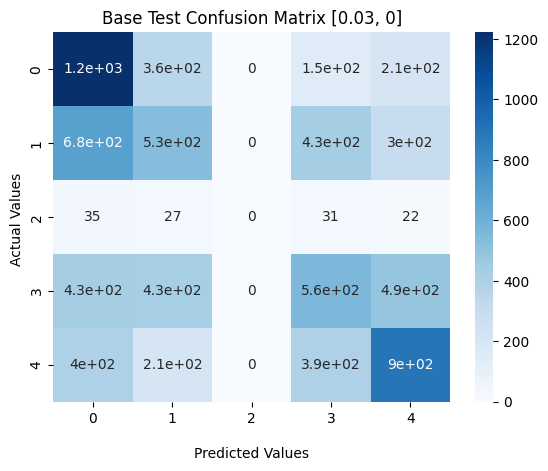

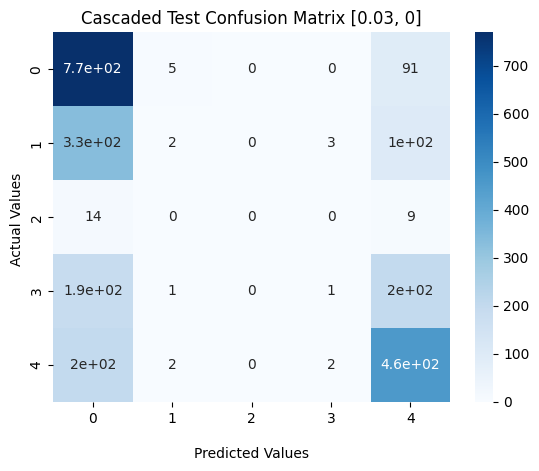

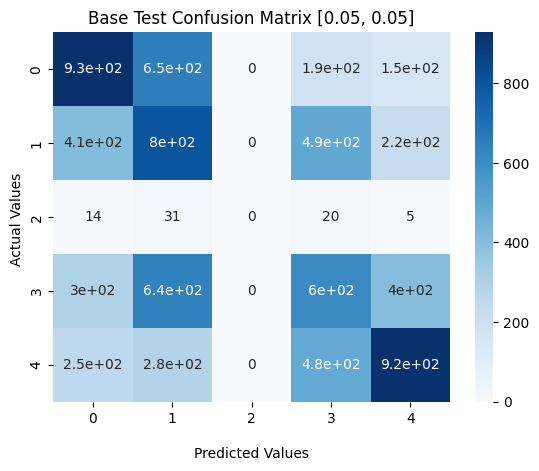

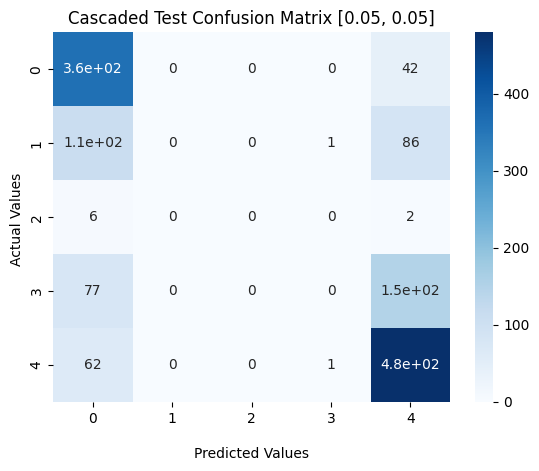

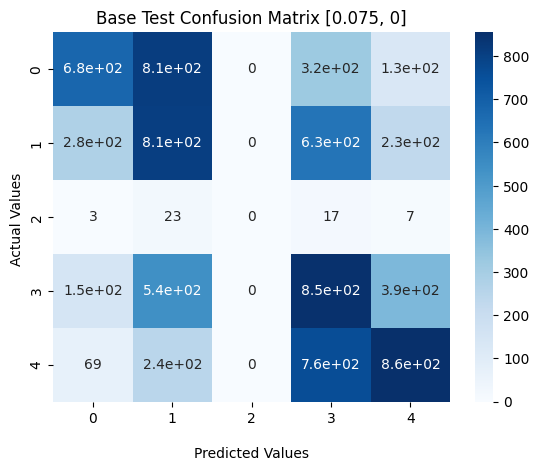

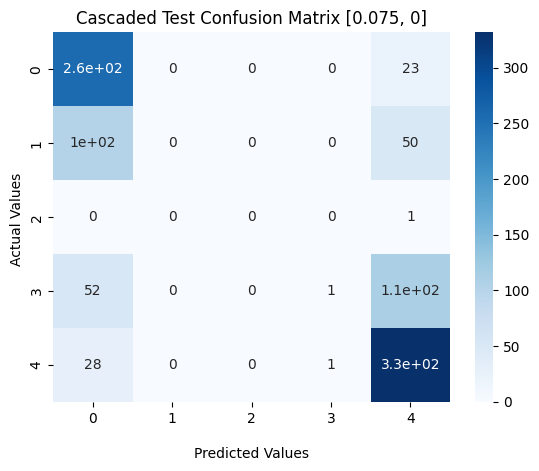

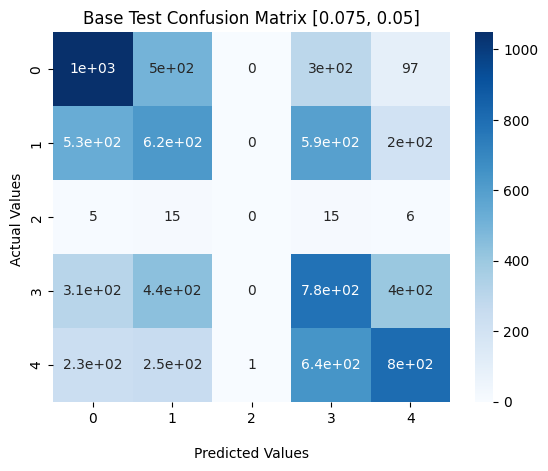

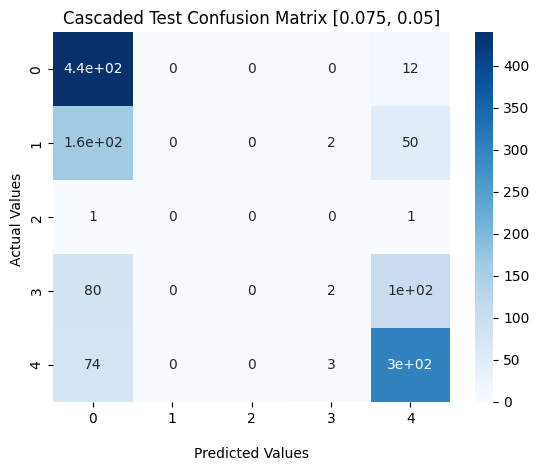

In [ ]:
for i, cm in enumerate(cms):
    base_cm, cascaded_cm = cm
     ### base test confusion matrix
    disp = sns.heatmap(base_cm, annot = True, cmap = 'Blues')
    disp.set_title(f"Base Test Confusion Matrix {sigmaL[i]}")
    disp.set_xlabel('\nPredicted Values')
    disp.set_ylabel('Actual Values ')
    disp.xaxis.set_ticklabels([0,1,2,3,4])
    disp.yaxis.set_ticklabels([0,1,2,3,4])
    plt.show()

    disp = sns.heatmap(cascaded_cm, annot = True, cmap = 'Blues')
    disp.set_title(f"Cascaded Test Confusion Matrix {sigmaL[i]}")
    disp.set_xlabel('\nPredicted Values')
    disp.set_ylabel('Actual Values ')
    plt.show()

In [ ]:
### calculate weighted sum of accs
train_comb = []
test_comb = []
train_support = []
test_support = []
for s in range(len(train_accs)):
    train_acc = 0
    test_acc = 0
    train_left = 1
    test_left = 1
    for i in range(levels):
        train_acc += train_accs[s][i] * train_unpruned[s][i] * train_left
        test_acc += test_accs[s][i] * test_unpruned[s][i] * test_left
        train_left -= train_unpruned[s][i] * train_left
        test_left -= test_unpruned[s][i] * test_left
    train_comb.append(train_acc/(1-train_left))
    test_comb.append(test_acc/(1-test_left))
    train_support.append(1-train_left)
    test_support.append(1-test_left)

In [ ]:
table = "<table>\n"
table += "<thead><caption>Training on data from all eras and testing on data with different set of eras.</caption>\n"
table += "<th>Noise</th>"
for i in range(levels):
    table += f"<th colspan = \"4\">MODEL {i+1}</th>"
table += f"<th colspan = \"2\">BASE MODEL</th><th colspan = \"4\">COMBINATION</th>"
table += "\n"
table += "</thead><tbody>\n<tr>"
table += "<td></td>"
for i in range(levels):
    table += "<td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td>"
table += "<td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td>Test Support</td>"
table += "</tr>\n"
for s in range(len(sigmaL)):
    table += f"<tr><td>{sigmaL[s]}</td>"
    for i in range(levels):
        table += f"<td>{train_accs[s][i]:.3f}</td>"
        table += f"<td>{train_unpruned[s][i]:.3f}</td>"
        table += f"<td>{test_accs[s][i]:.3f}</td>"
        table += f"<td>{train_unpruned[s][i]:.3f}</td>"
        table += "\n"
    table += f"<td>{base_train[s]:.3f}</td><td>{base_test[s]:.3f}</td><td>{train_comb[s]:.3f}</td><td>{test_comb[s]:.3f}</td><td>{train_support[s]:.3f}</td><td>{test_support[s]:.3f}</td>\n"
    table += "</tr>"
table += "</tbody></table>"
print(table)

<table>
<thead><caption>Training on data from all eras and testing on data with different set of eras.</caption>
<th>Noise</th><th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td></td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td>Test Support</td></tr>
<tr><td>[0, 0]</td><td>0.974</td><td>0.974</td><td>0.770</td><td>0.974</td>
<td>0.925</td><td>0.912</td><td>0.523</td><td>0.912</td>
<td>0.800</td><td>0.556</td><td>0.167</td><td>0.556</td>
<td>0.965</td><td>0.753</td><td>0.973</td><td>0.757</td><td>0.999</td><td>1.000</td>
</tr><tr><td>[0, 0.05]</td><td>0.947</td><td>0.918</td><

### Train on clean data and test on noisy data

In [ ]:
train_accs = []
test_accs = []
train_unpruned = []
test_unpruned = []
base_train = []
base_test = []

levels = 3
for sid in sigmaL[1:]:
    print(f"{sid}")
    trainf=pd.read_csv(DATAPATH+f'df_syn_train_0_0_.csv')[COLS]
    testf=pd.read_csv(DATAPATH+f'df_syn_train_{sid[0]}_{sid[1]}_.csv')[COLS]

    ds_train=MyDS(trainf.iloc[:,0:-4].values,trainf.iloc[:,-3].values,task='regression')
    ds_test=MyDS(testf.iloc[:,0:-4].values,testf.iloc[:,-3].values,task='regression')
    ds_train.labels=np.array([int(l*4) for l in ds_train.labels])
    ds_test.labels=np.array([int(l*4) for l in ds_test.labels])

    ensemble = Ensemble(**ensemble_params)
    ensemble.fit(ds_train, ds_test, **fit_params)
    train_unpruned.append(ensemble.unpruned_train_data)
    train_accs.append(ensemble.train_accs)
    test_unpruned.append(ensemble.unpruned_test_data)
    test_accs.append(ensemble.test_accs)
    base_train.append(ensemble.base_train_acc)
    base_test.append(ensemble.base_test_acc)

    display.clear_output(wait = True)
print("DONE.")

DONE.


In [ ]:
### calculate weighted sum of accs
train_comb = []
test_comb = []
train_support = []
test_support = []
for s in range(len(train_accs)):
    train_acc = 0
    test_acc = 0
    train_left = 1
    test_left = 1
    for i in range(levels):
        train_acc += train_accs[s][i] * train_unpruned[s][i] * train_left
        test_acc += test_accs[s][i] * test_unpruned[s][i] * test_left
        train_left -= train_unpruned[s][i] * train_left
        test_left -= test_unpruned[s][i] * test_left
    train_comb.append(train_acc/(1-train_left))
    test_comb.append(test_acc/(1-test_left))
    train_support.append(1-train_left)
    test_support.append(1-test_left)

In [ ]:
table = "<table>\n"
table += "<thead><caption>Training on clean data and testing on noisy data</caption>\n"
table += "<th>Noise</th>"
for i in range(levels):
    table += f"<th colspan = \"4\">MODEL {i+1}</th>"
table += f"<th colspan = \"2\">BASE MODEL</th><th colspan = \"4\">COMBINATION</th>"
table += "\n"
table += "</thead><tbody>\n<tr>"
table += "<td></td>"
for i in range(levels):
    table += "<td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td>"
table += "<td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td>"
table += "</tr>\n"
for s in range(len(sigmaL)-1):
    table += f"<tr><td>{sigmaL[s]}</td>"
    for i in range(levels):
        table += f"<td>{train_accs[s][i]:.3f}</td>"
        table += f"<td>{train_unpruned[s][i]:.3f}</td>"
        table += f"<td>{test_accs[s][i]:.3f}</td>"
        table += f"<td>{train_unpruned[s][i]:.3f}</td>"
        table += "\n"
    table += f"<td>{base_train[s]:.3f}</td><td>{base_test[s]:.3f}</td><td>{train_comb[s]:.3f}</td><td>{test_comb[s]:.3f}</td><td>{train_support[s]:.3f}</td><td>{test_support[s]:.3f}</td>\n"
    table += "</tr>"
table += "</tbody></table>"
print(table)

<table>
<thead><caption>Training on clean data and testing on noisy data</caption>
<th>Noise</th><th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td></td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>[0, 0]</td><td>0.982</td><td>0.972</td><td>0.873</td><td>0.972</td>
<td>0.975</td><td>0.914</td><td>0.541</td><td>0.914</td>
<td>0.867</td><td>0.789</td><td>0.411</td><td>0.789</td>
<td>0.973</td><td>0.845</td><td>0.982</td><td>0.851</td><td>0.999</td><td>0.994</td>
</tr><tr><td>[0, 0.05]</td><td>0.979</td><td>0.977</td><td>0.396</td><td>0.977</td

### Train on noisy data and test on clean data

In [ ]:
train_accs = []
test_accs = []
train_unpruned = []
test_unpruned = []
base_train = []
base_test = []

levels = 3
for sid in sigmaL[1:]:
    print(f"{sid}")
    testf=pd.read_csv(DATAPATH+f'df_syn_train_0_0_.csv')[COLS]
    trainf=pd.read_csv(DATAPATH+f'df_syn_train_{sid[0]}_{sid[1]}_.csv')[COLS]

    ds_train=MyDS(trainf.iloc[:,0:-4].values,trainf.iloc[:,-3].values,task='regression')
    ds_test=MyDS(testf.iloc[:,0:-4].values,testf.iloc[:,-3].values,task='regression')
    ds_train.labels=np.array([int(l*4) for l in ds_train.labels])
    ds_test.labels=np.array([int(l*4) for l in ds_test.labels])

    ensemble = Ensemble(**ensemble_params)
    ensemble.fit(ds_train, ds_test, **fit_params)
    train_unpruned.append(ensemble.unpruned_train_data)
    train_accs.append(ensemble.train_accs)
    test_unpruned.append(ensemble.unpruned_test_data)
    test_accs.append(ensemble.test_accs)
    base_train.append(ensemble.base_train_acc)
    base_test.append(ensemble.base_test_acc)

    display.clear_output(wait = True)
print("DONE.")

DONE.


In [ ]:
### calculate weighted sum of accs
train_comb = []
test_comb = []
train_support = []
test_support = []
for s in range(len(train_accs)):
    train_acc = 0
    test_acc = 0
    train_left = 1
    test_left = 1
    for i in range(levels):
        train_acc += train_accs[s][i] * train_unpruned[s][i] * train_left
        test_acc += test_accs[s][i] * test_unpruned[s][i] * test_left
        train_left -= train_unpruned[s][i] * train_left
        test_left -= test_unpruned[s][i] * test_left
    train_comb.append(train_acc/(1-train_left))
    test_comb.append(test_acc/(1-test_left))
    train_support.append(1-train_left)
    test_support.append(1-test_left)

In [ ]:
table = "<table>\n"
table += "<thead><caption>Training on noisy data and testing on clean data</caption>\n"
table += "<th>Noise</th>"
for i in range(levels):
    table += f"<th colspan = \"4\">MODEL {i+1}</th>"
table += f"<th colspan = \"2\">BASE MODEL</th><th colspan = \"4\">COMBINATION</th>"
table += "\n"
table += "</thead><tbody>\n<tr>"
table += "<td></td>"
for i in range(levels):
    table += "<td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td>"
table += "<td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td>"
table += "</tr>\n"
for s in range(len(train_accs)):
    table += f"<tr><td>{sigmaL[s+1]}</td>"
    for i in range(levels):
        table += f"<td>{train_accs[s][i]:.3f}</td>"
        table += f"<td>{train_unpruned[s][i]:.3f}</td>"
        table += f"<td>{test_accs[s][i]:.3f}</td>"
        table += f"<td>{train_unpruned[s][i]:.3f}</td>"
        table += "\n"
    table += f"<td>{base_train[s]:.3f}</td><td>{base_test[s]:.3f}</td><td>{train_comb[s]:.3f}</td><td>{test_comb[s]:.3f}</td><td>{train_support[s]:.3f}</td><td>{test_support[s]:.3f}</td>\n"
    table += "</tr>"
table += "</tbody></table>"
print(table)

<table>
<thead><caption>Training on noisy data and testing on clean data</caption>
<th>Noise</th><th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td></td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>[0, 0.05]</td><td>0.946</td><td>0.923</td><td>0.918</td><td>0.923</td>
<td>0.855</td><td>0.561</td><td>0.519</td><td>0.561</td>
<td>0.860</td><td>0.351</td><td>0.600</td><td>0.351</td>
<td>0.914</td><td>0.887</td><td>0.941</td><td>0.897</td><td>0.978</td><td>0.968</td>
</tr><tr><td>[0.01, 0]</td><td>0.881</td><td>0.445</td><td>0.643</td><td>0.445<

### Train on a single era and test on the same era

In [ ]:
train_accs = []
test_accs = []
train_unpruned = []
test_unpruned = []
base_train = []
base_test= []

train_comb = []
test_comb = []
train_support = []
test_support = []

levels = 3
for sid in sigmaL:
    df_train=pd.read_csv(DATAPATH+f'df_syn_train_{sid[0]}_{sid[1]}_.csv')[COLS]
    df_test=pd.read_csv(DATAPATH+f'df_syn_test_{sid[0]}_{sid[1]}_.csv')[COLS]
    eras = df_train['era'].unique()

    s_train_accs = []
    s_train_unpruned = []
    s_test_accs = []
    s_test_unpruned = []
    s_train_base = []
    s_test_base = []

    s_train_comb = []
    s_test_comb = []
    s_train_support = []
    s_test_support = []

    for e in eras:
        print(f"{sid} {e}")
        df=df_train.loc[df_train['era'] == e]
        trainf, testf = df[0:int(0.8*df.shape[0])], df[int(0.8*df.shape[0]):]

        ds_train=MyDS(trainf.iloc[:,0:-4].values,trainf.iloc[:,-3].values,task='regression')
        ds_test=MyDS(testf.iloc[:,0:-4].values,testf.iloc[:,-3].values,task='regression')

        ds_train.labels=np.array([int(l*4) for l in ds_train.labels])
        ds_test.labels=np.array([int(l*4) for l in ds_test.labels])

        ensemble = Ensemble(**ensemble_params)
        ensemble.fit(ds_train, ds_test, **fit_params)

        s_train_unpruned.append(ensemble.unpruned_train_data)
        s_train_accs.append(ensemble.train_accs)
        s_test_unpruned.append(ensemble.unpruned_test_data)
        s_test_accs.append(ensemble.test_accs)
        s_train_base.append(ensemble.base_train_acc)
        s_test_base.append(ensemble.base_test_acc)

        train_acc = 0
        test_acc = 0
        train_left = 1
        test_left = 1
        for i in range(levels):
            train_acc +=ensemble.train_accs[i] * ensemble.unpruned_train_data[i] * train_left
            test_acc += ensemble.test_accs[i] * ensemble.unpruned_test_data[i] * test_left
            train_left -= ensemble.unpruned_train_data[i] * train_left
            test_left -= ensemble.unpruned_test_data[i] * test_left

        s_train_comb.append(train_acc/(1-train_left))
        s_test_comb.append(test_acc/(1-test_left))
        s_train_support.append(1-train_left)
        s_test_support.append(1-test_left)

        display.clear_output(wait = True)

    train_unpruned.append([ sum(x)/len(x) for x in zip(*s_train_unpruned)])
    train_accs.append([ sum(x)/len(x) for x in zip(*s_train_accs)])
    test_unpruned.append([ sum(x)/len(x) for x in zip(*s_test_unpruned)])
    test_accs.append([ sum(x)/len(x) for x in zip(*s_test_accs)])
    base_train.append(sum(s_train_base)/len(s_train_base))
    base_test.append(sum(s_test_base)/len(s_test_base))

    train_comb.append(sum(s_train_comb)/len(s_train_comb))
    test_comb.append(sum(s_test_comb)/len(s_test_comb))
    train_support.append(sum(s_train_support)/len(s_train_support))
    test_support.append(sum(s_test_support)/len(s_test_support))

print("DONE.")

DONE.


In [ ]:
table = "<table>\n"
table += "<thead><caption>Training on data from a single era and training on same era.</caption>\n"
table += "<th>Noise</th>"
for i in range(levels):
    table += f"<th colspan = \"4\">MODEL {i+1}</th>"
table += f"<th colspan = \"2\">BASE MODEL</th><th colspan=\"4\">COMBINATION</th>"
table += "\n"
table += "</thead><tbody>\n<tr>"
table += "<td></td>"
for i in range(levels):
    table += "<td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td>"
table += "<td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td>"
table += "</tr>\n"
for s in range(len(train_accs)):
    table += f"<tr><td>{sigmaL[s]}</td>"
    for i in range(levels):
        table += f"<td>{train_accs[s][i]:.3f}</td>"
        table += f"<td>{train_unpruned[s][i]:.3f}</td>"
        table += f"<td>{test_accs[s][i]:.3f}</td>"
        table += f"<td>{train_unpruned[s][i]:.3f}</td>"
        table += "\n"
    table += f"<td>{base_train[s]:.3f}</td><td>{base_test[s]:.3f}</td><td>{train_comb[s]:.3f}</td><td>{test_comb[s]:.3f}</td><td>{train_support[s]:.3f}</td><td>{test_support[s]:.3f}</td>\n"
    table += "</tr>"
table += "</tbody></table>"
print(table)

<table>
<thead><caption>Training on data from a single era and training on same era.</caption>
<th>Noise</th><th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan="4">COMBINATION</th>
</thead><tbody>
<tr><td></td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>[0, 0]</td><td>0.990</td><td>0.988</td><td>0.987</td><td>0.988</td>
<td>0.556</td><td>0.500</td><td>0.222</td><td>0.500</td>
<td>0.083</td><td>0.042</td><td>0.000</td><td>0.042</td>
<td>0.983</td><td>0.982</td><td>0.989</td><td>0.986</td><td>0.993</td><td>0.999</td>
</tr><tr><td>[0, 0.05]</td><td>0.969</td><td>0.967</td><td>0.926</td><td

### Train on a single era and test on a different era scatter done

In [ ]:
train_comb = []
test_comb = []
train_support = []
test_support = []
train_base = []
test_base  =[]
levels = 3
for sid in sigmaL:
    df_train=pd.read_csv(DATAPATH+f'df_syn_train_{sid[0]}_{sid[1]}_.csv')[COLS]
    df_test=pd.read_csv(DATAPATH+f'df_syn_train_test_{sid[0]}_{sid[1]}_.csv')[COLS]
    train_eras = df_train['era'].unique()
    test_eras = df_test['era'].unique()

    s_train_comb = []
    s_test_comb = []
    s_train_support = []
    s_test_support = []
    s_train_base = []
    s_test_base = []

    for train_era, test_era in zip(train_eras, test_eras):
        print(f"{sid} {train_era} {test_era}")
        trainf=df_train.loc[df_train['era'] == train_era]
        testf = df_test.loc[df_test['era'] == test_era]

        ds_train=MyDS(trainf.iloc[:,0:-4].values,trainf.iloc[:,-3].values,task='regression')
        ds_test=MyDS(testf.iloc[:,0:-4].values,testf.iloc[:,-3].values,task='regression')

        ds_train.labels=np.array([int(l*4) for l in ds_train.labels])
        ds_test.labels=np.array([int(l*4) for l in ds_test.labels])

        ensemble = Ensemble(**ensemble_params)
        ensemble.fit(ds_train, ds_test, **fit_params)

        s_train_base.append(ensemble.base_train_acc)
        s_test_base.append(ensemble.base_test_acc)

        train_acc = 0
        test_acc = 0
        train_left = 1
        test_left = 1
        for i in range(levels):
            train_acc += ensemble.train_accs[i] * ensemble.unpruned_train_data[i] * train_left
            test_acc += ensemble.test_accs[i] * ensemble.unpruned_test_data[i] * test_left
            train_left -= ensemble.unpruned_train_data[i] * train_left
            test_left -=ensemble.unpruned_test_data[i] * test_left
        s_train_comb.append(train_acc/(1-train_left))
        s_test_comb.append(test_acc/(1-test_left))
        s_train_support.append(1-train_left)
        s_test_support.append(1-test_left)

        display.clear_output(wait = True)

    train_comb.append(s_train_comb)
    test_comb.append(s_test_comb)
    train_support.append(s_train_support)
    test_support.append(s_test_support)
    train_base.append(s_train_base)
    test_base.append(s_test_base)

print("DONE.")

DONE.


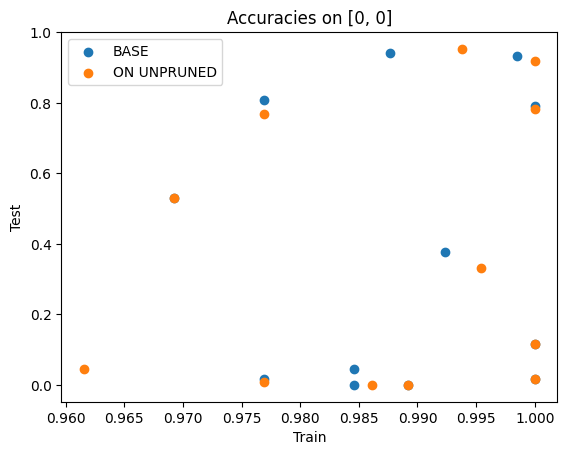

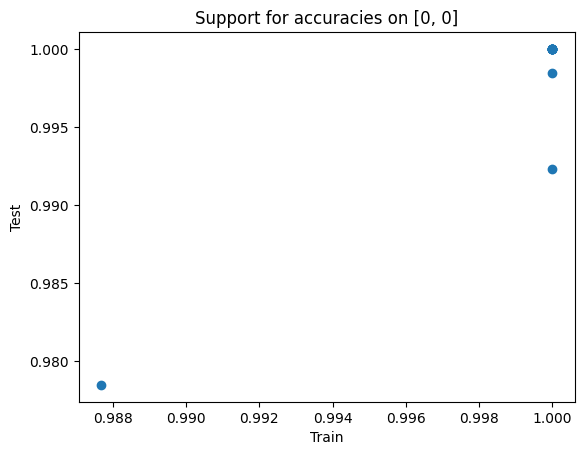

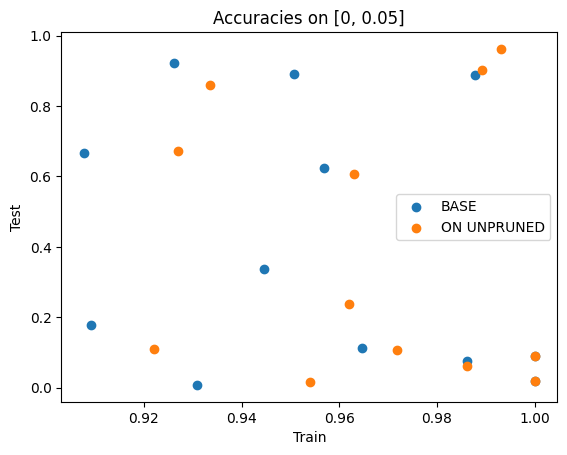

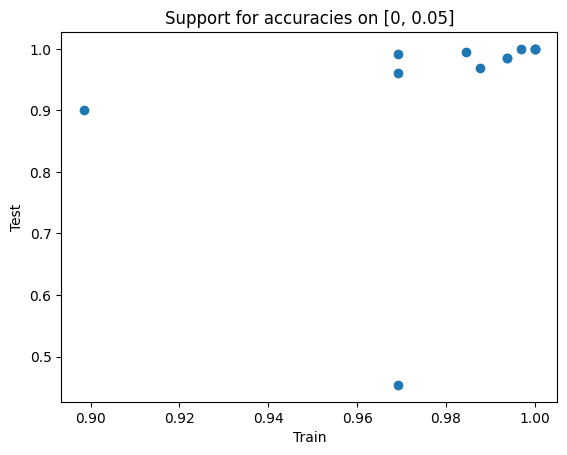

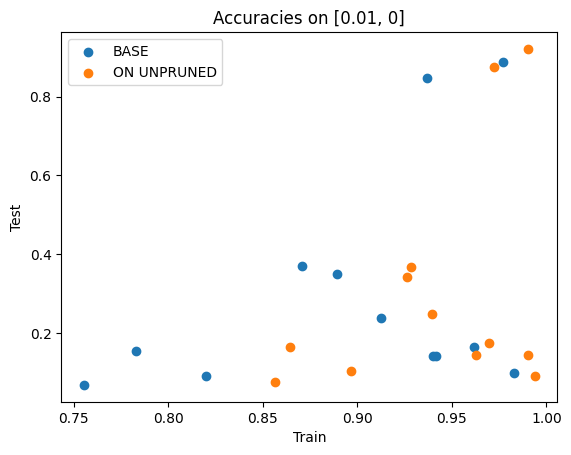

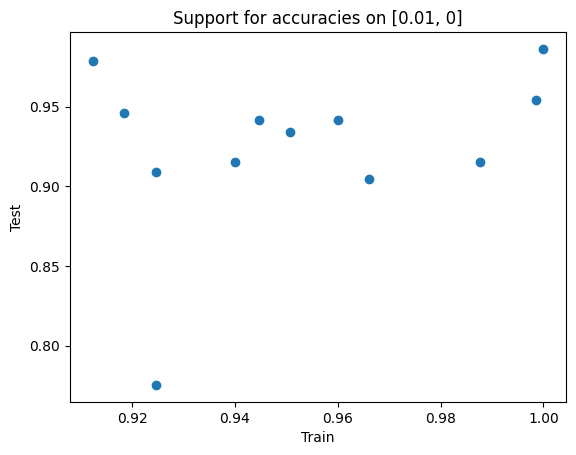

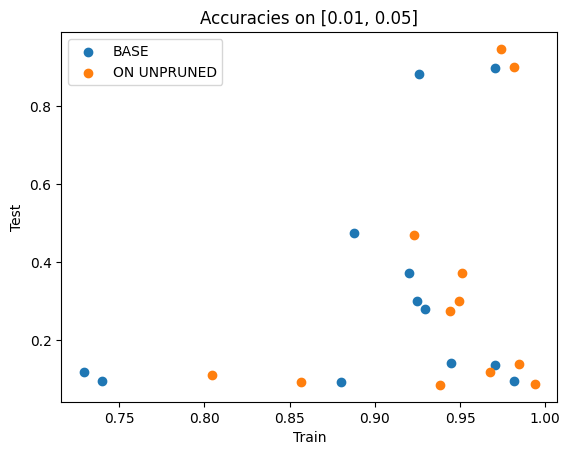

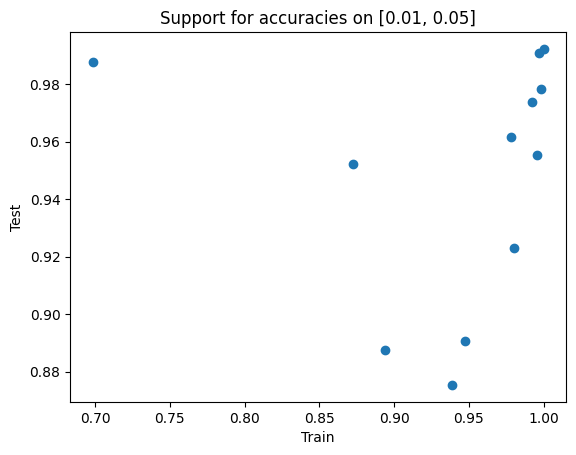

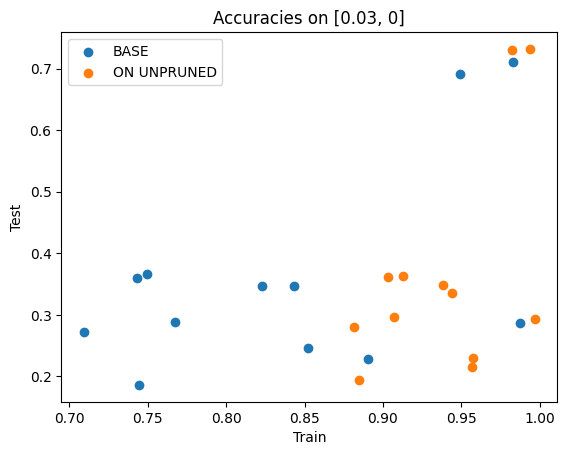

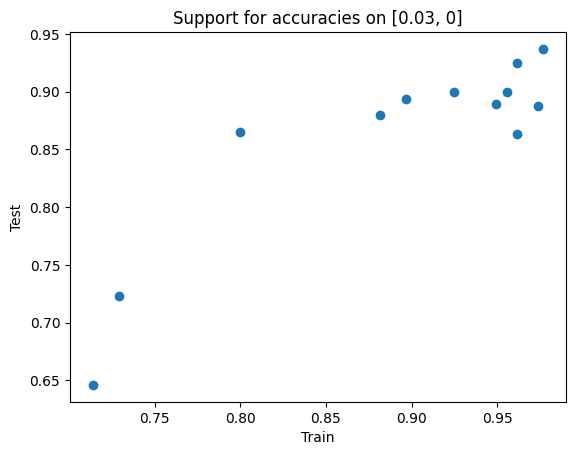

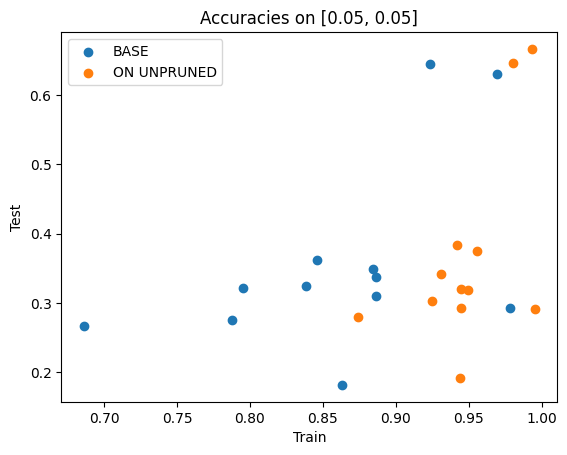

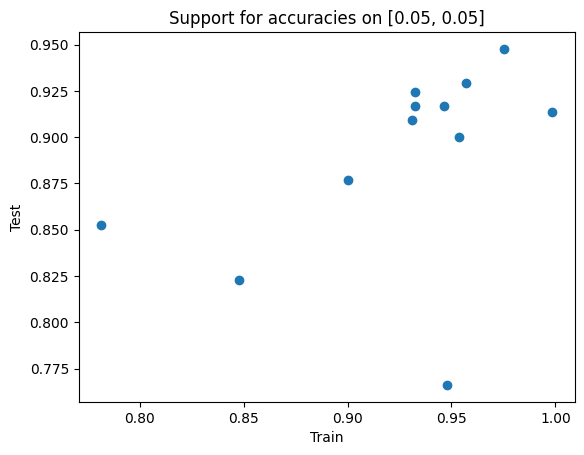

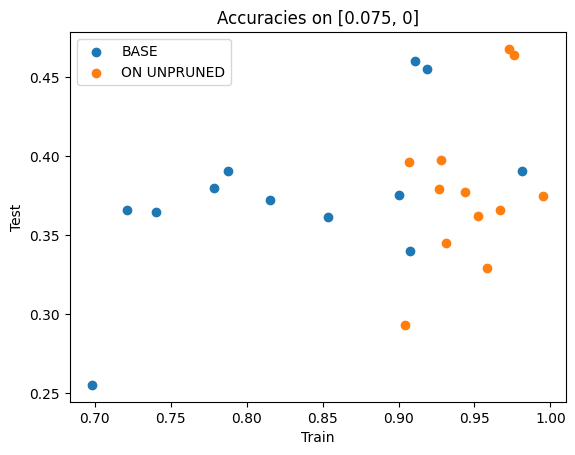

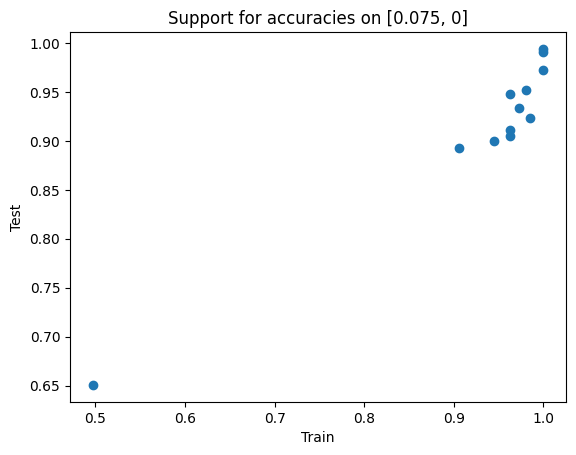

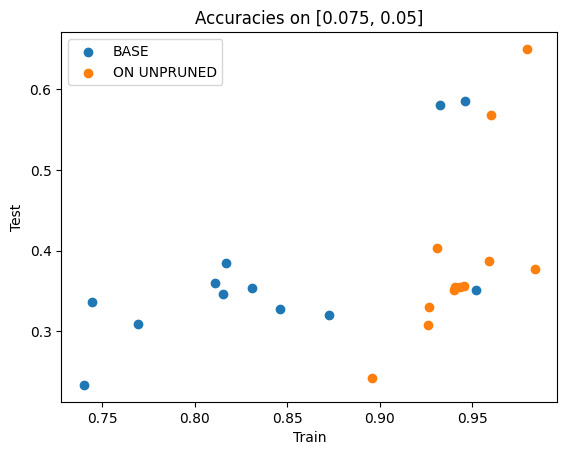

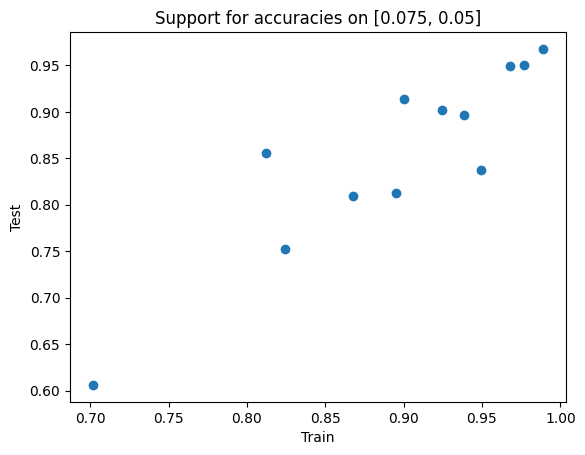

In [ ]:
### calculate weighted sum of accs

for s in range(len(sigmaL)):
    plt.title(f"Accuracies on {sigmaL[s]}")
    plt.xlabel("Train")
    plt.ylabel("Test")
    plt.scatter(train_base[s], test_base[s], alpha=1, label = "BASE")
    plt.scatter(train_comb[s], test_comb[s], alpha=1, label = "ON UNPRUNED")
    plt.legend()
    plt.show()

    plt.title(f"Support for accuracies on {sigmaL[s]}")
    plt.xlabel("Train")
    plt.ylabel("Test")
    plt.scatter(train_support[s], test_support[s], alpha=1)
    plt.show()



## Experiments on Real Data

In [ ]:
#ensemble_params = {'levels': 3, 'max_impurity': 0.5, 'max_depth': 4}
#fit_params = {'epochs': 1000, 'lr': 0.01, 'batch_size': 32, 'penalty_coeff': 1, 'beta':0.5}

### training on multiple eras and test on same set of eras (confusion done)

In [ ]:
df_train=pd.read_csv(DATAPATH+f'df_train.csv')
df_test=pd.read_csv(DATAPATH+f'df_test.csv')
eras = df_test['era'].unique()
trainf = pd.DataFrame()
testf = pd.DataFrame()
levels = 3
for e in eras:
    df=df_train.loc[df_train['era'] == e]
    train, test = df.iloc[0:int(0.8*df.shape[0])], df.iloc[int(0.8*df.shape[0]):]
    trainf = pd.concat([trainf, train])
    testf = pd.concat([testf, test])

ds_train=MyDS(trainf.iloc[:,0:-3].values,trainf.iloc[:,-2].values,task='regression')
ds_test=MyDS(testf.iloc[:,0:-3].values,testf.iloc[:,-2].values,task='regression')
ds_train.labels=np.array([int(l*4) for l in ds_train.labels])
ds_test.labels=np.array([int(l*4) for l in ds_test.labels])

ensemble = Ensemble(**ensemble_params)
ensemble.fit(ds_train, ds_test, **fit_params)
train_unpruned=ensemble.unpruned_train_data
train_accs=ensemble.train_accs
test_unpruned=ensemble.unpruned_test_data
test_accs=ensemble.test_accs
base_train=ensemble.base_train_acc
base_test=ensemble.base_test_acc


100%|██████████| 500/500 [22:32<00:00,  2.71s/it]


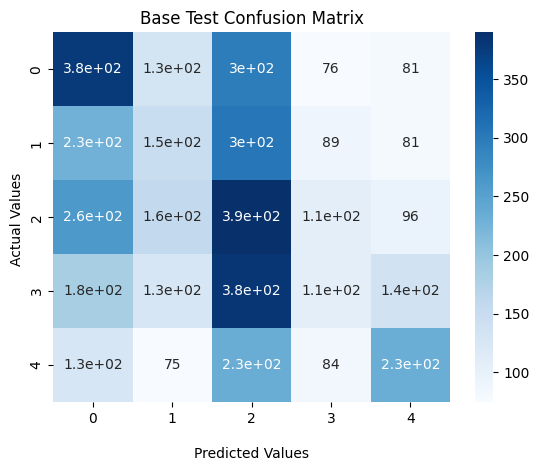

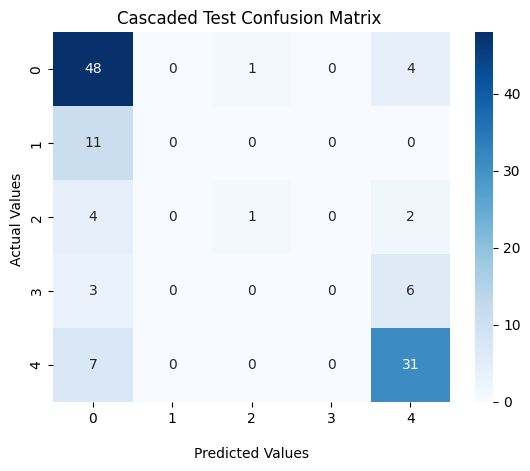

In [ ]:
disp = sns.heatmap(ensemble.base_test_cm, annot = True, cmap = 'Blues')
disp.set_title(f"Base Test Confusion Matrix")
disp.set_xlabel('\nPredicted Values')
disp.set_ylabel('Actual Values ')
disp.xaxis.set_ticklabels([0,1,2,3,4])
disp.yaxis.set_ticklabels([0,1,2,3,4])
plt.show()

disp = sns.heatmap(ensemble.cascaded_test_cm, annot = True, cmap = 'Blues')
disp.set_title(f"Cascaded Test Confusion Matrix ")
disp.set_xlabel('\nPredicted Values')
disp.set_ylabel('Actual Values ')
plt.show()

In [ ]:
train_acc = 0
test_acc = 0
train_left = 1
test_left = 1
for i in range(levels):
    train_acc += train_accs[i] * train_unpruned[i] * train_left
    test_acc += test_accs[i] * test_unpruned[i] * test_left
    train_left -= train_unpruned[i] * train_left
    test_left -= test_unpruned[i] * test_left
train_comb = train_acc/(1-train_left)
test_comb = test_acc/(1-test_left)
train_support = 1-train_left
test_support = 1-test_left

In [ ]:
table = "<table>\n"
table += "<thead><caption>Training and testing on the same set of eras</caption>\n"
for i in range(levels):
    table += f"<th colspan = \"4\">MODEL {i+1}</th>"
table += f"<th colspan = \"2\">BASE MODEL</th><th colspan = \"4\">COMBINATION</th>"
table += "\n"
table += "</thead><tbody>\n<tr>"
table += "<td></td>"
for i in range(levels):
    table += "<td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td>"
table += "<td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td>"
table += "</tr>\n"
table += "<tr>"
for i in range(levels):
    table += f"<td>{train_accs[i]:.3f}</td>"
    table += f"<td>{train_unpruned[i]:.3f}</td>"
    table += f"<td>{test_accs[i]:.3f}</td>"
    table += f"<td>{train_unpruned[i]:.3f}</td>"
    table += "\n"
table += f"<td>{base_train:.3f}</td><td>{base_test:.3f}</td><td>{train_comb:.3f}</td><td>{test_comb:.3f}</td><td>{train_support:.3f}</td><td>{test_support:.3f}</td>\n"
table += "</tr>"
table += "</tbody></table>"
print(table)

<table>
<thead><caption>Training and testing on the same set of eras</caption>
<th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td></td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>0.750</td><td>0.034</td><td>0.660</td><td>0.034</td>
<td>0.000</td><td>0.000</td><td>0.000</td><td>0.000</td>
<td>0.000</td><td>0.000</td><td>0.000</td><td>0.000</td>
<td>0.321</td><td>0.282</td><td>0.750</td><td>0.660</td><td>0.034</td><td>0.031</td>
</tr></tbody></table>


### Training on multiple eras and testing on a different set (confusion done)

In [9]:
df_train=pd.read_csv(DATAPATH+f'df_train.csv')
testf=pd.read_csv(DATAPATH+f'df_val.csv')
eras = df_train['era'].unique()
trainf = pd.DataFrame()
levels = 3
for e in eras[-15:]:
    df=df_train.loc[df_train['era'] == e]
    train, test = df.iloc[0:int(0.8*df.shape[0])], df.iloc[int(0.8*df.shape[0]):]
    trainf = pd.concat([trainf, train])

ds_train=MyDS(trainf.iloc[:,0:-3].values,trainf.iloc[:,-2].values,task='regression')
ds_test=MyDS(testf.iloc[:,0:-3].values,testf.iloc[:,-2].values,task='regression')
ds_train.labels=np.array([int(l*4) for l in ds_train.labels])
ds_test.labels=np.array([int(l*4) for l in ds_test.labels])

ensemble = DDTEnsemble(**ensemble_params)
ensemble.fit(ds_train, ds_test, **fit_params)
train_unpruned=ensemble.unpruned_train_data
train_accs=ensemble.train_accs
test_unpruned=ensemble.unpruned_test_data
test_accs=ensemble.test_accs
base_train=ensemble.base_train_acc
base_test=ensemble.base_test_acc


100%|█████████████████████████████████████████| 500/500 [16:12<00:00,  1.95s/it]


In [222]:
list(trainf.columns[0:-3].values)

['Open_n_val',
 'High_n_val',
 'Low_n_val',
 'Close_n_val',
 'Volume_n_val',
 'SMA_10_val',
 'SMA_20_val',
 'CMO_14_val',
 'High_n-Low_n_val',
 'Open_n-Close_n_val',
 'SMA_20-SMA_10_val',
 'Close_n_slope_3_val',
 'Close_n_slope_5_val',
 'Close_n_slope_10_val',
 'Open_n_changelen_val',
 'High_n_changelen_val',
 'Low_n_changelen_val',
 'Close_n_changelen_val',
 'High_n-Low_n_changelen_val',
 'Open_n-Close_n_changelen_val',
 'SMA_20-SMA_10_changelen_val',
 'Close_n_slope_3_changelen_val',
 'Close_n_slope_5_changelen_val',
 'Close_n_slope_10_changelen_val',
 'row_num']

In [10]:
# ensemble.save_models('./DDTModelDiff.pth')

In [153]:
ens=DDTEnsemble(**ensemble_params)

In [154]:
ens.load_models('./DDTModelDiff.pth')

In [137]:
import random
random.randint

<bound method Random.randint of <random.Random object at 0x12f032210>>

In [216]:
N=500
count=0
correct=0
notbad=0
for k in range(N):
    i=random.randint(0,ds_test.samples.shape[0])
    p=ens.forward(ds_test.samples[i].unsqueeze(0),max_impurity=.52)
    if p[0][0].item()>=0:
        # print(torch.argmax(p[0]),ds_test.labels[i],torch.argmax(p[0]).item()==ds_test.labels[i])
        if torch.argmax(p[0]).item()==ds_test.labels[i]: correct+=1
        if torch.argmax(p[0]).item()==0 and ds_test.labels[i]<=2: notbad+=1
        if torch.argmax(p[0]).item()==4 and ds_test.labels[i]>=2: notbad+=1
        count+=1
print(count/N,correct/count,notbad/count,count,correct,notbad)

0.048 0.3333333333333333 0.75 24 8 18


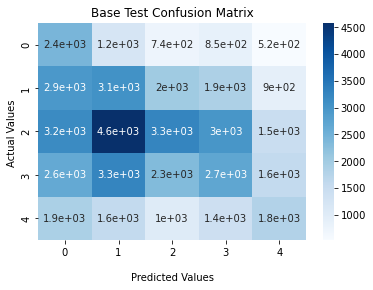

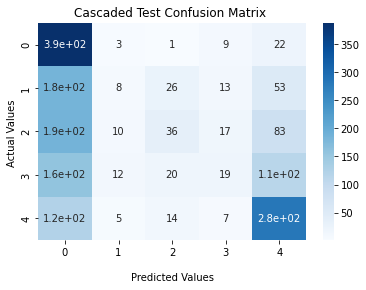

In [201]:
disp = sns.heatmap(ensemble.base_test_cm, annot = True, cmap = 'Blues')
disp.set_title(f"Base Test Confusion Matrix")
disp.set_xlabel('\nPredicted Values')
disp.set_ylabel('Actual Values ')
disp.xaxis.set_ticklabels([0,1,2,3,4])
disp.yaxis.set_ticklabels([0,1,2,3,4])
plt.show()

disp = sns.heatmap(ensemble.cascaded_test_cm, annot = True, cmap = 'Blues')
disp.set_title(f"Cascaded Test Confusion Matrix ")
disp.set_xlabel('\nPredicted Values')
disp.set_ylabel('Actual Values ')
plt.show()

In [ ]:
train_acc = 0
test_acc = 0
train_left = 1
test_left = 1
for i in range(levels):
    train_acc += train_accs[i] * train_unpruned[i] * train_left
    test_acc += test_accs[i] * test_unpruned[i] * test_left
    train_left -= train_unpruned[i] * train_left
    test_left -= test_unpruned[i] * test_left
train_comb = train_acc/(1-train_left)
test_comb = test_acc/(1-test_left)
train_support = 1-train_left
test_support = 1-test_left

In [ ]:
table = "<table>\n"
table += "<thead><caption>Training and testing on a different set of eras</caption>\n"
for i in range(levels):
    table += f"<th colspan = \"4\">MODEL {i+1}</th>"
table += f"<th colspan = \"2\">BASE MODEL</th><th colspan = \"4\">COMBINATION</th>"
table += "\n"
table += "</thead><tbody>\n<tr>"
table += "<td></td>"
for i in range(levels):
    table += "<td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td>"
table += "<td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td>"
table += "</tr>\n"
table += "<tr>"
for i in range(levels):
    table += f"<td>{train_accs[i]:.3f}</td>"
    table += f"<td>{train_unpruned[i]:.3f}</td>"
    table += f"<td>{test_accs[i]:.3f}</td>"
    table += f"<td>{train_unpruned[i]:.3f}</td>"
    table += "\n"
table += f"<td>{base_train:.3f}</td><td>{base_test:.3f}</td><td>{train_comb:.3f}</td><td>{test_comb:.3f}</td><td>{train_support:.3f}</td><td>{test_support:.3f}</td>\n"
table += "</tr>"
table += "</tbody></table>"
print(table)

<table>
<thead><caption>Training and testing on a different set of eras</caption>
<th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td></td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>0.875</td><td>0.002</td><td>0.477</td><td>0.002</td>
<td>0.796</td><td>0.024</td><td>0.476</td><td>0.024</td>
<td>0.667</td><td>0.000</td><td>0.368</td><td>0.000</td>
<td>0.333</td><td>0.265</td><td>0.802</td><td>0.475</td><td>0.026</td><td>0.022</td>
</tr></tbody></table>


### Training on a single era and testing on the same era

In [ ]:
df_train=pd.read_csv(DATAPATH+f'df_train.csv')
eras = df_train['era'].unique()

s_train_accs = []
s_train_unpruned = []
s_test_accs = []
s_test_unpruned = []
s_train_base = []
s_test_base = []


s_train_comb = []
s_test_comb = []
s_train_support = []
s_test_support = []

for e in eras[-20:]:
    print(e)
    df=df_train.loc[df_train['era'] == e]
    trainf, testf = df[0:int(0.8*df.shape[0])], df[int(0.8*df.shape[0]):]

    ds_train=MyDS(trainf.iloc[:,0:-3].values,trainf.iloc[:,-2].values,task='regression')
    ds_test=MyDS(testf.iloc[:,0:-3].values,testf.iloc[:,-2].values,task='regression')

    ds_train.labels=np.array([int(l*4) for l in ds_train.labels])
    ds_test.labels=np.array([int(l*4) for l in ds_test.labels])

    ensemble = Ensemble(**ensemble_params)
    ensemble.fit(ds_train, ds_test, **fit_params)

    s_train_unpruned.append(ensemble.unpruned_train_data)
    s_train_accs.append(ensemble.train_accs)
    s_test_unpruned.append(ensemble.unpruned_test_data)
    s_test_accs.append(ensemble.test_accs)
    s_train_base.append(ensemble.base_train_acc)
    s_test_base.append(ensemble.base_test_acc)

    train_acc = 0
    test_acc = 0
    train_left = 1
    test_left = 1
    for i in range(levels):
        train_acc +=ensemble.train_accs[i] * ensemble.unpruned_train_data[i] * train_left
        test_acc += ensemble.test_accs[i] * ensemble.unpruned_test_data[i] * test_left
        train_left -= ensemble.unpruned_train_data[i] * train_left
        test_left -= ensemble.unpruned_test_data[i] * test_left

    s_train_comb.append(train_acc/(1-train_left))
    s_test_comb.append(test_acc/(1-test_left))
    s_train_support.append(1-train_left)
    s_test_support.append(1-test_left)

    display.clear_output(wait=True)


train_unpruned = [sum(x)/len(x) for x in zip(*s_train_unpruned)]
train_accs = [ sum(x)/len(x) for x in zip(*s_train_accs)]
test_unpruned = [ sum(x)/len(x) for x in zip(*s_test_unpruned)]
test_accs = [ sum(x)/len(x) for x in zip(*s_test_accs)]
base_train = sum(s_train_base)/len(s_train_base)
base_test = sum(s_test_base)/len(s_test_base)
train_comb = sum(s_train_comb)/len(s_train_comb)
test_comb = sum(s_test_comb)/len(s_test_comb)
train_support = sum(s_train_support)/len(s_train_support)
test_support = sum(s_test_support)/len(s_test_support)

213


100%|██████████| 500/500 [00:30<00:00, 16.21it/s]


In [ ]:
table = "<table>\n"
table += "<thead><caption>Training on a single era and testing on the same era</caption>\n"
for i in range(levels):
    table += f"<th colspan = \"4\">MODEL {i+1}</th>"
table += f"<th colspan = \"2\">BASE MODEL</th><th colspan = \"4\">COMBINATION</th>"
table += "\n"
table += "</thead><tbody>\n<tr>"
table += "<td></td>"
for i in range(levels):
    table += "<td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td>"
table += "<td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td>"
table += "</tr>\n"
table += "<tr>"
for i in range(levels):
    table += f"<td>{train_accs[i]:.3f}</td>"
    table += f"<td>{train_unpruned[i]:.3f}</td>"
    table += f"<td>{test_accs[i]:.3f}</td>"
    table += f"<td>{train_unpruned[i]:.3f}</td>"
    table += "\n"
table += f"<td>{base_train:.3f}</td><td>{base_test:.3f}</td><td>{train_comb:.3f}</td><td>{test_comb:.3f}</td><td>{train_support:.3f}</td><td>{test_support:.3f}</td>\n"
table += "</tr>"
table += "</tbody></table>"
print(table)

<table>
<thead><caption>Training on a single era and testing on the same era</caption>
<th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td></td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>0.976</td><td>0.876</td><td>0.301</td><td>0.876</td>
<td>0.936</td><td>0.767</td><td>0.202</td><td>0.767</td>
<td>0.495</td><td>0.380</td><td>0.109</td><td>0.380</td>
<td>0.940</td><td>0.288</td><td>0.980</td><td>0.274</td><td>0.986</td><td>0.949</td>
</tr></tbody></table>


### Training on a single era and testing on a different era (scatter done)

In [ ]:
df_train = pd.read_csv(DATAPATH+f'df_train.csv')
df_test = pd.read_csv(DATAPATH+f'df_val.csv')
train_eras = df_train['era'].unique()
test_eras = df_test['era'].unique()

train_base = []
test_base  =[]

train_comb = []
test_comb = []
train_support = []
test_support = []

for train_era, test_era in zip(train_eras, test_eras):
    print(f"{train_era} {test_era}")
    trainf =df_train.loc[df_train['era'] == train_era]
    testf =df_test.loc[df_test['era'] == test_era]

    ds_train=MyDS(trainf.iloc[:,0:-3].values,trainf.iloc[:,-2].values,task='regression')
    ds_test=MyDS(testf.iloc[:,0:-3].values,testf.iloc[:,-2].values,task='regression')

    ds_train.labels=np.array([int(l*4) for l in ds_train.labels])
    ds_test.labels=np.array([int(l*4) for l in ds_test.labels])

    ensemble = Ensemble(**ensemble_params)
    ensemble.fit(ds_train, ds_test, **fit_params)

    train_base.append(ensemble.base_train_acc)
    test_base.append(ensemble.base_test_acc)

    train_acc = 0
    test_acc = 0
    train_left = 1
    test_left = 1
    for i in range(levels):
        train_acc +=ensemble.train_accs[i] * ensemble.unpruned_train_data[i] * train_left
        test_acc += ensemble.test_accs[i] * ensemble.unpruned_test_data[i] * test_left
        train_left -= ensemble.unpruned_train_data[i] * train_left
        test_left -= ensemble.unpruned_test_data[i] * test_left

    train_comb.append(train_acc/(1-train_left))
    test_comb.append(test_acc/(1-test_left))
    train_support.append(1-train_left)
    test_support.append(1-test_left)
    display.clear_output(wait=True)

107 550


100%|██████████| 500/500 [00:03<00:00, 145.21it/s]


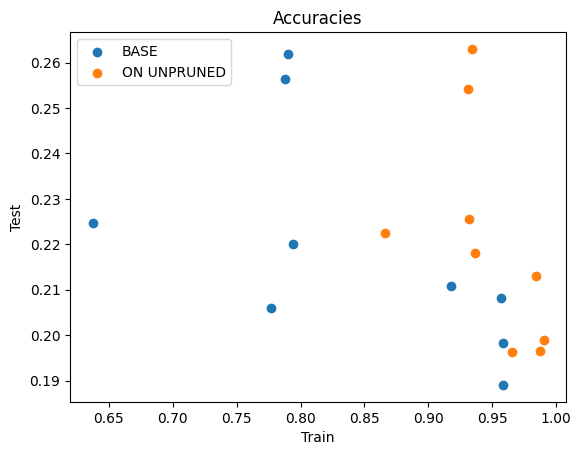

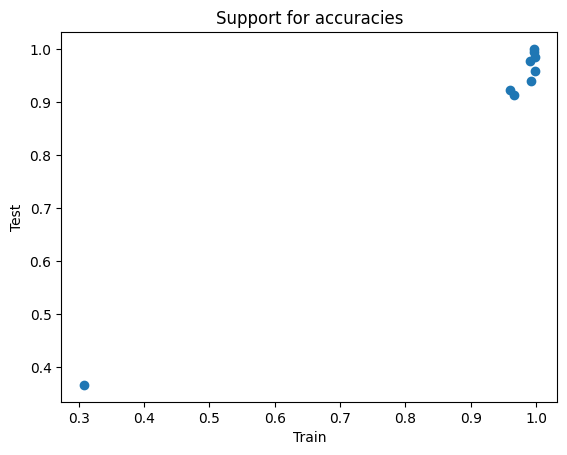

In [ ]:
plt.title(f"Accuracies")
plt.xlabel("Train")
plt.ylabel("Test")
plt.scatter(train_base, test_base, alpha=1, label = "BASE")
plt.scatter(train_comb, test_comb, alpha=1, label = "ON UNPRUNED")
plt.legend()
plt.show()

plt.title(f"Support for accuracies")
plt.xlabel("Train")
plt.ylabel("Test")
plt.scatter(train_support, test_support, alpha=1)
plt.show()


# Results

### df_syn_x_x

<table>
<thead><caption>Training on data from all eras and testing on data with same set of eras.</caption>
<th>Noise</th><th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td></td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>[0, 0]</td><td>0.975</td><td>0.968</td><td>0.973</td><td>0.968</td>
<td>0.887</td><td>0.800</td><td>0.913</td><td>0.800</td>
<td>1.000</td><td>0.525</td><td>1.000</td><td>0.525</td>
<td>0.964</td><td>0.964</td><td>0.973</td><td>0.972</td><td>0.997</td><td>0.993</td>
</tr><tr><td>[0, 0.05]</td><td>0.960</td><td>0.915</td><td>0.911</td><td>0.915</td>
<td>0.879</td><td>0.501</td><td>0.671</td><td>0.501</td>
<td>1.000</td><td>0.049</td><td>0.500</td><td>0.049</td>
<td>0.926</td><td>0.866</td><td>0.957</td><td>0.897</td><td>0.960</td><td>0.954</td>
</tr><tr><td>[0.01, 0]</td><td>0.928</td><td>0.356</td><td>0.872</td><td>0.356</td>
<td>0.796</td><td>0.026</td><td>0.481</td><td>0.026</td>
<td>0.745</td><td>0.091</td><td>0.446</td><td>0.091</td>
<td>0.659</td><td>0.604</td><td>0.899</td><td>0.808</td><td>0.430</td><td>0.420</td>
</tr><tr><td>[0.01, 0.05]</td><td>0.882</td><td>0.509</td><td>0.837</td><td>0.509</td>
<td>0.785</td><td>0.198</td><td>0.570</td><td>0.198</td>
<td>0.786</td><td>0.179</td><td>0.549</td><td>0.179</td>
<td>0.710</td><td>0.676</td><td>0.858</td><td>0.775</td><td>0.677</td><td>0.690</td>
</tr><tr><td>[0.03, 0]</td><td>0.841</td><td>0.290</td><td>0.775</td><td>0.290</td>
<td>0.718</td><td>0.037</td><td>0.564</td><td>0.037</td>
<td>0.571</td><td>0.002</td><td>0.000</td><td>0.002</td>
<td>0.554</td><td>0.522</td><td>0.830</td><td>0.759</td><td>0.317</td><td>0.322</td>
</tr><tr><td>[0.05, 0.05]</td><td>0.883</td><td>0.214</td><td>0.780</td><td>0.214</td>
<td>0.733</td><td>0.041</td><td>0.630</td><td>0.041</td>
<td>0.592</td><td>0.066</td><td>0.522</td><td>0.066</td>
<td>0.551</td><td>0.485</td><td>0.818</td><td>0.726</td><td>0.296</td><td>0.288</td>
</tr><tr><td>[0.075, 0]</td><td>0.828</td><td>0.185</td><td>0.732</td><td>0.185</td>
<td>0.692</td><td>0.005</td><td>0.429</td><td>0.005</td>
<td>0.704</td><td>0.039</td><td>0.578</td><td>0.039</td>
<td>0.516</td><td>0.470</td><td>0.808</td><td>0.706</td><td>0.221</td><td>0.224</td>
</tr><tr><td>[0.075, 0.05]</td><td>0.858</td><td>0.179</td><td>0.796</td><td>0.179</td>
<td>0.661</td><td>0.067</td><td>0.562</td><td>0.067</td>
<td>0.727</td><td>0.005</td><td>0.556</td><td>0.005</td>
<td>0.546</td><td>0.457</td><td>0.810</td><td>0.738</td><td>0.237</td><td>0.230</td>
</tr></tbody></table>

<table>
<thead><caption>Training on data from all eras and testing on data with different set of eras.</caption>
<th>Noise</th><th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td></td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>[0, 0]</td><td>0.974</td><td>0.974</td><td>0.770</td><td>0.974</td>
<td>0.925</td><td>0.912</td><td>0.523</td><td>0.912</td>
<td>0.800</td><td>0.556</td><td>0.167</td><td>0.556</td>
<td>0.965</td><td>0.753</td><td>0.973</td><td>0.757</td><td>0.999</td><td>1.000</td>
</tr><tr><td>[0, 0.05]</td><td>0.947</td><td>0.918</td><td>0.845</td><td>0.918</td>
<td>0.898</td><td>0.461</td><td>0.122</td><td>0.461</td>
<td>0.875</td><td>0.303</td><td>0.191</td><td>0.303</td>
<td>0.914</td><td>0.779</td><td>0.944</td><td>0.785</td><td>0.969</td><td>0.953</td>
</tr><tr><td>[0.01, 0]</td><td>0.850</td><td>0.468</td><td>0.598</td><td>0.468</td>
<td>0.759</td><td>0.057</td><td>0.394</td><td>0.057</td>
<td>0.625</td><td>0.004</td><td>0.462</td><td>0.004</td>
<td>0.655</td><td>0.461</td><td>0.843</td><td>0.579</td><td>0.500</td><td>0.484</td>
</tr><tr><td>[0.01, 0.05]</td><td>0.886</td><td>0.547</td><td>0.658</td><td>0.547</td>
<td>0.714</td><td>0.115</td><td>0.398</td><td>0.115</td>
<td>0.701</td><td>0.077</td><td>0.412</td><td>0.077</td>
<td>0.734</td><td>0.538</td><td>0.863</td><td>0.622</td><td>0.630</td><td>0.628</td>
</tr><tr><td>[0.03, 0]</td><td>0.903</td><td>0.231</td><td>0.590</td><td>0.231</td>
<td>0.793</td><td>0.005</td><td>0.403</td><td>0.005</td>
<td>0.762</td><td>0.017</td><td>0.507</td><td>0.017</td>
<td>0.568</td><td>0.405</td><td>0.894</td><td>0.570</td><td>0.248</td><td>0.175</td>
</tr><tr><td>[0.05, 0.05]</td><td>0.954</td><td>0.101</td><td>0.694</td><td>0.101</td>
<td>0.907</td><td>0.020</td><td>0.667</td><td>0.020</td>
<td>0.703</td><td>0.145</td><td>0.563</td><td>0.145</td>
<td>0.515</td><td>0.382</td><td>0.821</td><td>0.598</td><td>0.247</td><td>0.182</td>
</tr><tr><td>[0.075, 0]</td><td>0.863</td><td>0.101</td><td>0.631</td><td>0.101</td>
<td>0.911</td><td>0.008</td><td>0.583</td><td>0.008</td>
<td>0.687</td><td>0.154</td><td>0.576</td><td>0.154</td>
<td>0.501</td><td>0.413</td><td>0.766</td><td>0.588</td><td>0.246</td><td>0.216</td>
</tr><tr><td>[0.075, 0.05]</td><td>0.898</td><td>0.139</td><td>0.652</td><td>0.139</td>
<td>0.753</td><td>0.012</td><td>0.657</td><td>0.012</td>
<td>0.679</td><td>0.096</td><td>0.563</td><td>0.096</td>
<td>0.532</td><td>0.412</td><td>0.814</td><td>0.612</td><td>0.231</td><td>0.195</td>
</tr></tbody></table>

<table>
<thead><caption>Training on clean data and testing on noisy data</caption>
<th>Noise</th><th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td></td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>[0, 0]</td><td>0.982</td><td>0.972</td><td>0.873</td><td>0.972</td>
<td>0.975</td><td>0.914</td><td>0.541</td><td>0.914</td>
<td>0.867</td><td>0.789</td><td>0.411</td><td>0.789</td>
<td>0.973</td><td>0.845</td><td>0.982</td><td>0.851</td><td>0.999</td><td>0.994</td>
</tr><tr><td>[0, 0.05]</td><td>0.979</td><td>0.977</td><td>0.396</td><td>0.977</td>
<td>0.858</td><td>0.960</td><td>0.229</td><td>0.960</td>
<td>1.000</td><td>1.000</td><td>0.123</td><td>1.000</td>
<td>0.969</td><td>0.389</td><td>0.977</td><td>0.385</td><td>1.000</td><td>0.999</td>
</tr><tr><td>[0.01, 0]</td><td>0.975</td><td>0.961</td><td>0.450</td><td>0.961</td>
<td>0.941</td><td>0.957</td><td>0.225</td><td>0.957</td>
<td>1.000</td><td>0.692</td><td>0.450</td><td>0.692</td>
<td>0.955</td><td>0.439</td><td>0.974</td><td>0.440</td><td>0.999</td><td>0.999</td>
</tr><tr><td>[0.01, 0.05]</td><td>0.984</td><td>0.980</td><td>0.367</td><td>0.980</td>
<td>0.955</td><td>0.836</td><td>0.271</td><td>0.836</td>
<td>1.000</td><td>0.154</td><td>0.043</td><td>0.154</td>
<td>0.976</td><td>0.359</td><td>0.984</td><td>0.361</td><td>0.997</td><td>0.992</td>
</tr><tr><td>[0.03, 0]</td><td>0.980</td><td>0.974</td><td>0.369</td><td>0.974</td>
<td>0.938</td><td>0.937</td><td>0.147</td><td>0.937</td>
<td>1.000</td><td>0.231</td><td>0.129</td><td>0.231</td>
<td>0.972</td><td>0.364</td><td>0.979</td><td>0.355</td><td>0.999</td><td>0.993</td>
</tr><tr><td>[0.05, 0.05]</td><td>0.979</td><td>0.969</td><td>0.364</td><td>0.969</td>
<td>0.892</td><td>0.933</td><td>0.245</td><td>0.933</td>
<td>0.769</td><td>0.812</td><td>0.286</td><td>0.812</td>
<td>0.966</td><td>0.361</td><td>0.976</td><td>0.359</td><td>1.000</td><td>0.995</td>
</tr><tr><td>[0.075, 0]</td><td>0.976</td><td>0.976</td><td>0.357</td><td>0.976</td>
<td>0.970</td><td>0.897</td><td>0.283</td><td>0.897</td>
<td>1.000</td><td>0.526</td><td>0.125</td><td>0.526</td>
<td>0.970</td><td>0.350</td><td>0.976</td><td>0.351</td><td>0.999</td><td>0.987</td>
</tr></tbody></table>

<table>
<thead><caption>Training on noisy data and testing on clean data</caption>
<th>Noise</th><th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td></td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>[0, 0.05]</td><td>0.946</td><td>0.923</td><td>0.918</td><td>0.923</td>
<td>0.855</td><td>0.561</td><td>0.519</td><td>0.561</td>
<td>0.860</td><td>0.351</td><td>0.600</td><td>0.351</td>
<td>0.914</td><td>0.887</td><td>0.941</td><td>0.897</td><td>0.978</td><td>0.968</td>
</tr><tr><td>[0.01, 0]</td><td>0.881</td><td>0.445</td><td>0.643</td><td>0.445</td>
<td>0.725</td><td>0.033</td><td>0.245</td><td>0.033</td>
<td>0.781</td><td>0.008</td><td>0.353</td><td>0.008</td>
<td>0.667</td><td>0.492</td><td>0.874</td><td>0.616</td><td>0.467</td><td>0.485</td>
</tr><tr><td>[0.01, 0.05]</td><td>0.876</td><td>0.558</td><td>0.669</td><td>0.558</td>
<td>0.704</td><td>0.088</td><td>0.459</td><td>0.088</td>
<td>0.776</td><td>0.091</td><td>0.348</td><td>0.091</td>
<td>0.729</td><td>0.553</td><td>0.859</td><td>0.611</td><td>0.634</td><td>0.613</td>
</tr><tr><td>[0.03, 0]</td><td>0.890</td><td>0.239</td><td>0.600</td><td>0.239</td>
<td>0.780</td><td>0.025</td><td>0.273</td><td>0.025</td>
<td>0.708</td><td>0.004</td><td>0.633</td><td>0.004</td>
<td>0.566</td><td>0.367</td><td>0.880</td><td>0.556</td><td>0.261</td><td>0.359</td>
</tr><tr><td>[0.05, 0.05]</td><td>0.846</td><td>0.228</td><td>0.628</td><td>0.228</td>
<td>0.000</td><td>0.000</td><td>0.000</td><td>0.000</td>
<td>0.755</td><td>0.016</td><td>0.424</td><td>0.016</td>
<td>0.538</td><td>0.344</td><td>0.841</td><td>0.593</td><td>0.241</td><td>0.170</td>
</tr><tr><td>[0.075, 0]</td><td>0.857</td><td>0.126</td><td>0.761</td><td>0.126</td>
<td>0.678</td><td>0.093</td><td>0.294</td><td>0.093</td>
<td>0.790</td><td>0.010</td><td>0.448</td><td>0.010</td>
<td>0.509</td><td>0.305</td><td>0.787</td><td>0.538</td><td>0.215</td><td>0.271</td>
</tr><tr><td>[0.075, 0.05]</td><td>0.864</td><td>0.187</td><td>0.638</td><td>0.187</td>
<td>0.000</td><td>0.000</td><td>0.000</td><td>0.000</td>
<td>0.750</td><td>0.009</td><td>0.533</td><td>0.009</td>
<td>0.525</td><td>0.397</td><td>0.859</td><td>0.628</td><td>0.194</td><td>0.198</td>
</tr></tbody></table>

<table>
<thead><caption>Training on data from a single era and training on same era.</caption>
<th>Noise</th><th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan="4">COMBINATION</th>
</thead><tbody>
<tr><td></td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>[0, 0]</td><td>0.990</td><td>0.988</td><td>0.987</td><td>0.988</td>
<td>0.556</td><td>0.500</td><td>0.222</td><td>0.500</td>
<td>0.083</td><td>0.042</td><td>0.000</td><td>0.042</td>
<td>0.983</td><td>0.982</td><td>0.989</td><td>0.986</td><td>0.993</td><td>0.999</td>
</tr><tr><td>[0, 0.05]</td><td>0.969</td><td>0.967</td><td>0.926</td><td>0.967</td>
<td>0.796</td><td>0.361</td><td>0.481</td><td>0.361</td>
<td>0.333</td><td>0.072</td><td>0.000</td><td>0.072</td>
<td>0.956</td><td>0.907</td><td>0.969</td><td>0.918</td><td>0.980</td><td>0.967</td>
</tr><tr><td>[0.01, 0]</td><td>0.950</td><td>0.874</td><td>0.701</td><td>0.874</td>
<td>0.879</td><td>0.433</td><td>0.405</td><td>0.433</td>
<td>0.639</td><td>0.224</td><td>0.069</td><td>0.224</td>
<td>0.909</td><td>0.675</td><td>0.950</td><td>0.682</td><td>0.940</td><td>0.908</td>
</tr><tr><td>[0.01, 0.05]</td><td>0.943</td><td>0.891</td><td>0.765</td><td>0.891</td>
<td>0.802</td><td>0.442</td><td>0.218</td><td>0.442</td>
<td>0.745</td><td>0.517</td><td>0.203</td><td>0.517</td>
<td>0.904</td><td>0.737</td><td>0.944</td><td>0.744</td><td>0.930</td><td>0.929</td>
</tr><tr><td>[0.03, 0]</td><td>0.945</td><td>0.714</td><td>0.594</td><td>0.714</td>
<td>0.985</td><td>0.576</td><td>0.313</td><td>0.576</td>
<td>0.971</td><td>0.462</td><td>0.296</td><td>0.462</td>
<td>0.852</td><td>0.547</td><td>0.956</td><td>0.557</td><td>0.909</td><td>0.879</td>
</tr><tr><td>[0.05, 0.05]</td><td>0.934</td><td>0.711</td><td>0.557</td><td>0.711</td>
<td>0.792</td><td>0.462</td><td>0.309</td><td>0.462</td>
<td>0.470</td><td>0.134</td><td>0.021</td><td>0.134</td>
<td>0.851</td><td>0.522</td><td>0.942</td><td>0.526</td><td>0.851</td><td>0.827</td>
</tr><tr><td>[0.075, 0]</td><td>0.962</td><td>0.776</td><td>0.480</td><td>0.776</td>
<td>0.991</td><td>0.587</td><td>0.227</td><td>0.587</td>
<td>0.916</td><td>0.532</td><td>0.169</td><td>0.532</td>
<td>0.894</td><td>0.448</td><td>0.968</td><td>0.442</td><td>0.941</td><td>0.906</td>
</tr><tr><td>[0.075, 0.05]</td><td>0.949</td><td>0.748</td><td>0.512</td><td>0.748</td>
<td>0.911</td><td>0.557</td><td>0.288</td><td>0.557</td>
<td>0.649</td><td>0.274</td><td>0.094</td><td>0.274</td>
<td>0.868</td><td>0.485</td><td>0.959</td><td>0.486</td><td>0.907</td><td>0.834</td>
</tr></tbody></table>

### Real data results

<table>
<thead><caption>Training and testing on the same set of eras</caption>
<th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>0.819</td><td>0.008</td><td>0.651</td><td>0.008</td>
<td>0.720</td><td>0.004</td><td>0.615</td><td>0.004</td>
<td>0.667</td><td>0.000</td><td>1.000</td><td>0.000</td>
<td>0.342</td><td>0.278</td><td>0.784</td><td>0.649</td><td>0.012</td><td>0.013</td>
</tr></tbody></table>

<table>
<thead><caption>Training and testing on a different set of eras</caption>
<th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>0.816</td><td>0.041</td><td>0.409</td><td>0.041</td>
<td>0.737</td><td>0.012</td><td>0.278</td><td>0.012</td>
<td>0.750</td><td>0.000</td><td>0.528</td><td>0.000</td>
<td>0.392</td><td>0.273</td><td>0.798</td><td>0.375</td><td>0.053</td><td>0.046</td>
</tr></tbody></table>

<table>
<thead><caption>Training on a single era and testing on the same era</caption>
<th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>0.976</td><td>0.876</td><td>0.301</td><td>0.876</td>
<td>0.936</td><td>0.767</td><td>0.202</td><td>0.767</td>
<td>0.495</td><td>0.380</td><td>0.109</td><td>0.380</td>
<td>0.940</td><td>0.288</td><td>0.980</td><td>0.274</td><td>0.986</td><td>0.949</td>
</tr></tbody></table>

![image.png](attachment:image.png)

![image.png](attachment:image.png)

### Real data -depth 4 and 1000 epochs

<table>
<thead><caption>Training and testing on the same set of eras</caption>
<th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>0.750</td><td>0.034</td><td>0.660</td><td>0.034</td>
<td>0.000</td><td>0.000</td><td>0.000</td><td>0.000</td>
<td>0.000</td><td>0.000</td><td>0.000</td><td>0.000</td>
<td>0.321</td><td>0.282</td><td>0.750</td><td>0.660</td><td>0.034</td><td>0.031</td>
</tr></tbody></table>

<table>
<thead><caption>Training and testing on a different set of eras</caption>
<th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>0.875</td><td>0.002</td><td>0.477</td><td>0.002</td>
<td>0.796</td><td>0.024</td><td>0.476</td><td>0.024</td>
<td>0.667</td><td>0.000</td><td>0.368</td><td>0.000</td>
<td>0.333</td><td>0.265</td><td>0.802</td><td>0.475</td><td>0.026</td><td>0.022</td>
</tr></tbody></table>

<table>
<thead><caption>Training on a single era and testing on the same era</caption>
<th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>0.976</td><td>0.876</td><td>0.301</td><td>0.876</td>
<td>0.936</td><td>0.767</td><td>0.202</td><td>0.767</td>
<td>0.495</td><td>0.380</td><td>0.109</td><td>0.380</td>
<td>0.940</td><td>0.288</td><td>0.980</td><td>0.274</td><td>0.986</td><td>0.949</td>
</tr></tbody></table>

# Results on NUMERAI

### importing and setting up the data - finding 25 features most correlated to the target

In [36]:
#numerai data IMPORT
train = pd.read_parquet("494_v4_1_train.parquet")
train = train[train.columns[0:-36]]
val = pd.read_parquet("494_v4_1_validation.parquet")
train_eras = train['era'].unique()
val = val[val.columns[:-36]]
val = val.dropna()
val_eras = val['era'].unique()
df_train = train.loc[train['era'].isin(train_eras[-10:])]
df_val = val.loc[val['era'].isin(val_eras[-10:])]

In [37]:
df_train.columns

Index(['era', 'data_type', 'feature_honoured_observational_balaamite',
       'feature_polaroid_vadose_quinze', 'feature_untidy_withdrawn_bargeman',
       'feature_genuine_kyphotic_trehala',
       'feature_unenthralled_sportful_schoolhouse',
       'feature_divulsive_explanatory_ideologue',
       'feature_ichthyotic_roofed_yeshiva',
       'feature_waggly_outlandish_carbonisation',
       ...
       'feature_revisional_ablutionary_depression',
       'feature_yokelish_metapsychological_lunt',
       'feature_circumlunar_chaliced_seam',
       'feature_squallier_prototypal_dammar', 'feature_cognate_elating_ravine',
       'feature_ethiopian_carminative_retentivity',
       'feature_alabamian_outlying_monitoring',
       'feature_byzantine_festinate_mannose',
       'feature_sleetier_sea_potamogeton', 'target'],
      dtype='object', length=1589)

In [38]:
##find highest features most correlated to target.
correlations = df_train.drop(['era', 'data_type', 'target'], axis = 1).corrwith(df_train['target'])
correlations = correlations.abs().sort_values(ascending=False)

In [39]:
extracted_cols = []
for feature in correlations.keys():
    extracted_cols.append(feature)

In [40]:
extracted_cols = extracted_cols[0:25]
extracted_cols.append('era')
extracted_cols.append('target')
df_train = df_train[extracted_cols]
df_val = df_val[extracted_cols]
extracted_cols

['feature_utmost_excitable_emir',
 'feature_approximal_telautographic_sharkskin',
 'feature_datival_crucial_chevrotain',
 'feature_incorporating_abominable_daily',
 'feature_polypoid_taken_upgrader',
 'feature_wendish_synchronal_advertency',
 'feature_untinned_dextrogyrate_fining',
 'feature_marled_coliform_proctorship',
 'feature_pulverized_unified_dupery',
 'feature_protonematal_springtime_varioloid',
 'feature_saleable_unreprimanded_sacrosanctity',
 'feature_walnut_sceptical_crystallization',
 'feature_optic_mycelial_whimper',
 'feature_contaminable_exilic_girandole',
 'feature_inserted_inconvertible_functioning',
 'feature_sodding_choosy_eruption',
 'feature_dissident_templed_shippon',
 'feature_nymphomaniac_cleaned_museologist',
 'feature_geomorphological_uncompanioned_colander',
 'feature_guardant_irrepealable_onanist',
 'feature_rococo_unexceptional_tropicbird',
 'feature_couthie_inexplicit_reinfection',
 'feature_depressant_blinded_yellowstone',
 'feature_teratogenic_wet_calkin

In [41]:
train_eras = df_train['era'].unique()
val_eras = df_val['era'].unique()

In [42]:
ensemble_params = {'levels': 3, 'max_impurity': 0.5, 'max_depth': 4}
fit_params = {'epochs': 1000, 'lr': 0.01, 'batch_size': 32, 'penalty_coeff': 1, 'beta':0.5}

### training on multiple eras and test on same set of eras

In [43]:
eras = df_train['era'].unique()
trainf = pd.DataFrame()
testf = pd.DataFrame()
levels = 3
for e in eras:
    df=df_train.loc[df_train['era'] == e]
    train, test = df.iloc[0:int(0.8*df.shape[0])], df.iloc[int(0.8*df.shape[0]):] 
    trainf = pd.concat([trainf, train])
    testf = pd.concat([testf, test])

ds_train=MyDS(trainf.iloc[:,0:-2].values,trainf.iloc[:,-1].values,task='regression')
ds_test=MyDS(testf.iloc[:,0:-2].values,testf.iloc[:,-1].values,task='regression')
ds_train.labels=np.array([int(l*4) for l in ds_train.labels])
ds_test.labels=np.array([int(l*4) for l in ds_test.labels])

ensemble = Ensemble(**ensemble_params)
ensemble.fit(ds_train, ds_test, **fit_params)
train_unpruned=ensemble.unpruned_train_data
train_accs=ensemble.train_accs
test_unpruned=ensemble.unpruned_test_data
test_accs=ensemble.test_accs
base_train=ensemble.base_train_acc
base_test=ensemble.base_test_acc


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [2:22:39<00:00,  8.56s/it]


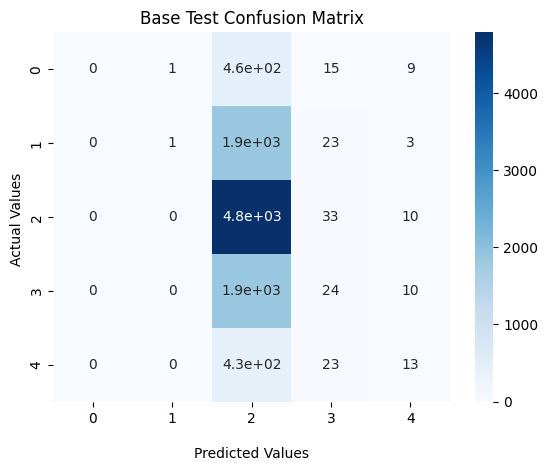

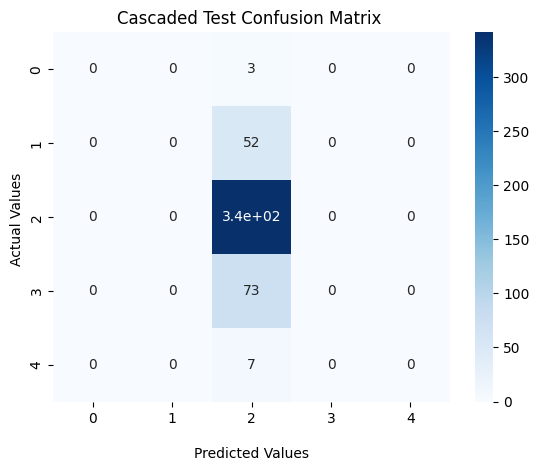

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
disp = sns.heatmap(ensemble.base_test_cm, annot = True, cmap = 'Blues')
disp.set_title(f"Base Test Confusion Matrix")
disp.set_xlabel('\nPredicted Values')
disp.set_ylabel('Actual Values ')
disp.xaxis.set_ticklabels([0,1,2,3,4])
disp.yaxis.set_ticklabels([0,1,2,3,4])
plt.show()

disp = sns.heatmap(ensemble.cascaded_test_cm, annot = True, cmap = 'Blues')
disp.set_title(f"Cascaded Test Confusion Matrix ")
disp.set_xlabel('\nPredicted Values')
disp.set_ylabel('Actual Values ')
plt.show()

In [46]:
train_acc = 0
test_acc = 0
train_left = 1
test_left = 1
for i in range(levels):
    train_acc += train_accs[i] * train_unpruned[i] * train_left
    test_acc += test_accs[i] * test_unpruned[i] * test_left
    train_left -= train_unpruned[i] * train_left
    test_left -= test_unpruned[i] * test_left
train_comb = train_acc/(1-train_left)
test_comb = test_acc/(1-test_left)
train_support = 1-train_left
test_support = 1-test_left

In [47]:
table = "<table>\n"
table += "<thead><caption>Training and testing on the same set of eras</caption>\n"
for i in range(levels):
    table += f"<th colspan = \"4\">MODEL {i+1}</th>"
table += f"<th colspan = \"2\">BASE MODEL</th><th colspan = \"4\">COMBINATION</th>"
table += "\n"
table += "</thead><tbody>\n<tr>"
table += "<td></td>"
for i in range(levels):
    table += "<td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td>"
table += "<td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td>"
table += "</tr>\n"
table += "<tr>"
for i in range(levels):
    table += f"<td>{train_accs[i]:.3f}</td>"
    table += f"<td>{train_unpruned[i]:.3f}</td>"
    table += f"<td>{test_accs[i]:.3f}</td>"
    table += f"<td>{train_unpruned[i]:.3f}</td>"
    table += "\n"
table += f"<td>{base_train:.3f}</td><td>{base_test:.3f}</td><td>{train_comb:.3f}</td><td>{test_comb:.3f}</td><td>{train_support:.3f}</td><td>{test_support:.3f}</td>\n"
table += "</tr>"
table += "</tbody></table>"
print(table)

<table>
<thead><caption>Training and testing on the same set of eras</caption>
<th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td></td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>0.686</td><td>0.004</td><td>0.806</td><td>0.004</td>
<td>0.697</td><td>0.042</td><td>0.701</td><td>0.042</td>
<td>0.689</td><td>0.004</td><td>0.800</td><td>0.004</td>
<td>0.499</td><td>0.505</td><td>0.695</td><td>0.717</td><td>0.049</td><td>0.050</td>
</tr></tbody></table>


### Training on multiple eras and testing on a different set

In [48]:
testf=df_val
eras = df_train['era'].unique()
trainf = pd.DataFrame()
levels = 3
for e in eras[-15:]:
    df=df_train.loc[df_train['era'] == e]
    train, test = df.iloc[0:int(0.8*df.shape[0])], df.iloc[int(0.8*df.shape[0]):]
    trainf = pd.concat([trainf, train])

ds_train=MyDS(trainf.iloc[:,0:-2].values,trainf.iloc[:,-1].values,task='regression')
ds_test=MyDS(testf.iloc[:,0:-2].values,testf.iloc[:,-1].values,task='regression')
ds_train.labels=np.array([int(l*4) for l in ds_train.labels])
ds_test.labels=np.array([int(l*4) for l in ds_test.labels])

ensemble = Ensemble(**ensemble_params)
ensemble.fit(ds_train, ds_test, **fit_params)
train_unpruned=ensemble.unpruned_train_data
train_accs=ensemble.train_accs
test_unpruned=ensemble.unpruned_test_data
test_accs=ensemble.test_accs
base_train=ensemble.base_train_acc
base_test=ensemble.base_test_acc


 35%|█████████████████████████████████████▌                                                                      | 348/1000 [48:27<1:30:47,  8.36s/it]


KeyboardInterrupt: 

In [ ]:
import seaborn as sns
disp = sns.heatmap(ensemble.base_test_cm, annot = True, cmap = 'Blues')
disp.set_title(f"Base Test Confusion Matrix")
disp.set_xlabel('\nPredicted Values')
disp.set_ylabel('Actual Values ')
disp.xaxis.set_ticklabels([0,1,2,3,4])
disp.yaxis.set_ticklabels([0,1,2,3,4])
plt.show()

disp = sns.heatmap(ensemble.cascaded_test_cm, annot = True, cmap = 'Blues')
disp.set_title(f"Cascaded Test Confusion Matrix ")
disp.set_xlabel('\nPredicted Values')
disp.set_ylabel('Actual Values ')
plt.show()

In [ ]:
train_acc = 0
test_acc = 0
train_left = 1
test_left = 1
for i in range(levels):
    train_acc += train_accs[i] * train_unpruned[i] * train_left
    test_acc += test_accs[i] * test_unpruned[i] * test_left
    train_left -= train_unpruned[i] * train_left
    test_left -= test_unpruned[i] * test_left
train_comb = train_acc/(1-train_left)
test_comb = test_acc/(1-test_left)
train_support = 1-train_left
test_support = 1-test_left

In [ ]:
table = "<table>\n"
table += "<thead><caption>Training and testing on a different set of eras</caption>\n"
for i in range(levels):
    table += f"<th colspan = \"4\">MODEL {i+1}</th>"
table += f"<th colspan = \"2\">BASE MODEL</th><th colspan = \"4\">COMBINATION</th>"
table += "\n"
table += "</thead><tbody>\n<tr>"
table += "<td></td>"
for i in range(levels):
    table += "<td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td>"
table += "<td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td>"
table += "</tr>\n"
table += "<tr>"
for i in range(levels):
    table += f"<td>{train_accs[i]:.3f}</td>"
    table += f"<td>{train_unpruned[i]:.3f}</td>"
    table += f"<td>{test_accs[i]:.3f}</td>"
    table += f"<td>{train_unpruned[i]:.3f}</td>"
    table += "\n"
table += f"<td>{base_train:.3f}</td><td>{base_test:.3f}</td><td>{train_comb:.3f}</td><td>{test_comb:.3f}</td><td>{train_support:.3f}</td><td>{test_support:.3f}</td>\n"
table += "</tr>"
table += "</tbody></table>"
print(table)

## Results on Numerai

<table>
<thead><caption>Training and testing on the same set of eras</caption>
<th colspan = "4">MODEL 1</th><th colspan = "4">MODEL 2</th><th colspan = "4">MODEL 3</th><th colspan = "2">BASE MODEL</th><th colspan = "4">COMBINATION</th>
</thead><tbody>
<tr><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Train Unpruned</td><td>Test Acc</td><td>Test Unpruned</td><td>Train Acc</td><td>Test Acc</td><td>Train Acc</td><td>Test Acc</td><td>Train Support</td><td>Test Support</td></tr>
<tr><td>0.686</td><td>0.004</td><td>0.806</td><td>0.004</td>
<td>0.697</td><td>0.042</td><td>0.701</td><td>0.042</td>
<td>0.689</td><td>0.004</td><td>0.800</td><td>0.004</td>
<td>0.499</td><td>0.505</td><td>0.695</td><td>0.717</td><td>0.049</td><td>0.050</td>
</tr></tbody></table>